In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

file_path=r"new_query-result.csv"
cep=pd.read_csv(file_path)
ra_array = np.array(cep['ra']) * u.degree
dec_array = np.array(cep['dec']) * u.degree
distance_array = (np.array(cep['parallax']) * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = np.array(cep['pmra']) * u.mas / u.yr
pm_dec_array = np.array(cep['pmdec']) * u.mas / u.yr
radial_velocity_array = np.array(cep['radial_velocity']) * u.km / u.s
l=np.array(cep['l']) * u.degree
b=np.array(cep['b']) * u.degree 




'''cep=np.loadtxt('GC.txt')
ra_array = cep[1:, 2]* u.degree
dec_array =cep[1:, 3] * u.degree
distance_array = (cep[1:, 1] * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = cep[1:, 5] * u.mas / u.yr
pm_dec_array = cep[1:, 6] * u.mas / u.yr
radial_velocity_array = cep[1:, 4] * u.km / u.s
l=cep[1:, 7] * u.degree
b=cep[1:, 8]* u.degree '''


# Constants
U_sun, V_sun, W_sun = 11.1* u.km / u.s, 12.24* u.km / u.s, 7.25* u.km / u.s  # Solar motion (km/s)
V0 = 229   * u.km / u.s  # Galactic rotation speed (km/s)
R0 = 8.1 * u.kpc

# Function to transform coordinates
def transform_to_galactocentric(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity,l,b):
    c = SkyCoord(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pm_ra_cosdec,
                 pm_dec=pm_dec, radial_velocity=radial_velocity)
    g = c.transform_to(Galactocentric(galcen_distance=8.1 * u.kpc,  # Default distance to Galactic Center
                                      z_sun=0.020 * u.kpc,  # Default Sun's height above the Galactic plane
                                      galcen_v_sun=[11.1,12.24, 7.25] * (u.km / u.s)))
    
    x, y, z = g.x.value, g.y.value, g.z.value
    vx, vy, vz = g.v_x.value, g.v_y.value, g.v_z.value
    d=distance
    # Cylindrical coordinates and velocities
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    vc_R = (x * vx + y * vy) / R
    vc_phi = (-y * vx + x * vy) / R
    vc_z = vz  # same

# Spherical coordinates and velocities
    r = np.sqrt(x**2 + y**2 + z**2)
    theta_s = np.arccos(z / r)
    vs_r = (x * vx + y * vy + z * vz) / r
    vs_theta = (x * z * vx + y * z * vy - (x**2 + y**2) * vz) / (r * np.sqrt(x**2 + y**2))
    vs_phi = (-y * vx + x * vy) / np.sqrt(x**2 + y**2)
    r=np.sqrt(R0**2 + d**2 - 2 * R0 * d * np.cos(b) * np.cos(l))
    v_gsr=radial_velocity + U_sun * np.cos(b) * np.cos(l) + \
           V_sun * np.cos(b) * np.sin(l) + \
           W_sun * np.sin(b) + V0 * np.cos(b) * np.sin(l)
    

# Xue paper : 
    # Cartesian coordinates
    X, Y, Z = x, y, z
    U, V, W = vx, vy, vz  # Cartesian velocities


    r = np.sqrt(X**2 + Y**2 + Z**2)
    phi = np.arctan2(Y, X)
    theta = np.pi/2 - np.arctan2(Z, np.sqrt(X**2 + Y**2))

    # Spherical velocities
    V_r = (U * np.cos(phi) + V * np.sin(phi)) * np.sin(theta) + W * np.cos(theta)
    V_theta = (U * np.cos(phi) + V * np.sin(phi)) * np.cos(theta) - W * np.sin(theta)
    V_phi = U * np.sin(phi) - V * np.cos(phi)    

    v_c=(R/R0)*((v_gsr/(np.sin(l)*np.cos(b))+V0))
    

    return X,Y,Z,U,V,W,R, phi, z, vc_R, vc_phi, vc_z,vs_r,vs_theta,vs_phi, np.abs(z),r,v_gsr,v_c ,V_r,V_theta,V_phi
#plt.scatter((transform_to_galactocentric(ra_array,dec_array,distance_array,pm_ra_cosdec_array,pm_dec_array,radial_velocity_array)[0]),(transform_to_galactocentric(ra_array,dec_array,distance_array,pm_ra_cosdec_array,pm_dec_array,radial_velocity_array)[3]),s=1)


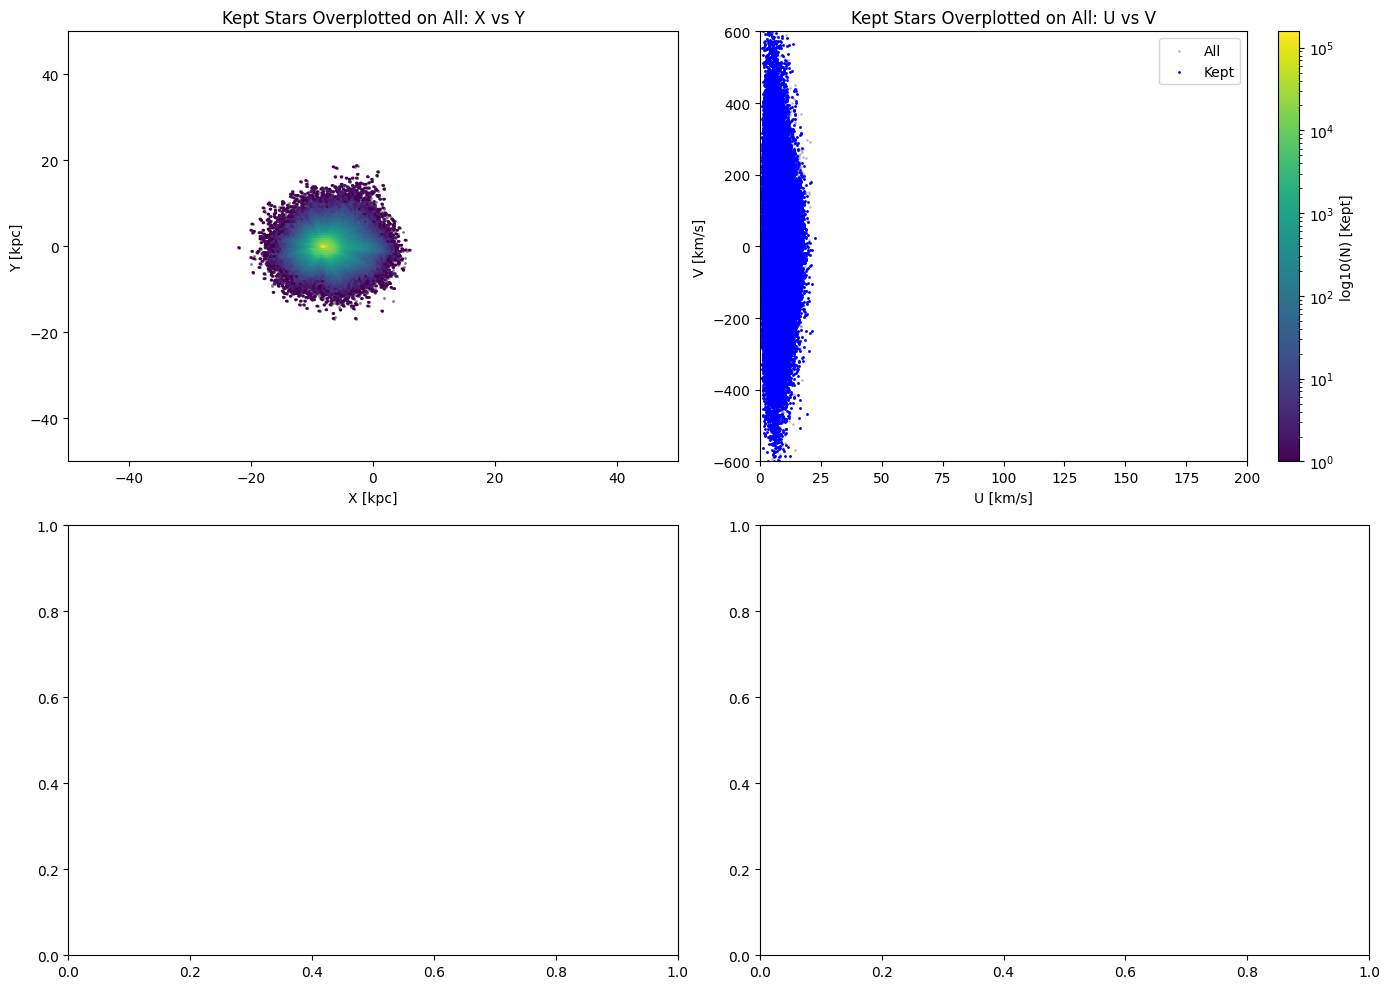

In [ ]:
import matplotlib.pyplot as plt

# Run the transformation
X, Y, Z, U, V, W, R, phi, z, vc_R, vc_phi, vc_z, vs_r, vs_theta, vs_phi, abs_z, r, v_gsr, v_c, V_r, V_theta, V_phi = \
    transform_to_galactocentric(ra_array, dec_array, distance_array,
                                 pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)

# ---------------------------------------
# Step 1: Define the mask to remove stars
# Example: Remove stars with |Z| > 5 kpc
# ---------------------------------------
mask_remove =z<-3
mask_keep = ~mask_remove

# ---------------------------------------
# Step 2: Plotting
# ---------------------------------------
k = 50  # axis limits

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from galpy.potential import MWPotential2014, evaluatePotentials
import astropy.units as u

V_r = vs_r * u.km/u.s
V_theta = vs_theta * u.km/u.s
V_phi = vs_phi * u.km/u.s
Z = z * u.kpc
r_gc = r * u.kpc

V_tot2 = V_r**2 + V_theta**2 + V_phi**2
V_tan = np.sqrt(V_theta**2 + V_phi**2)
L = (r_gc * V_tan).to(u.kpc * u.km/u.s)

R_galpy = (r_gc / (8.0 * u.kpc)).decompose().value
Z_galpy = (Z / (1.0 * u.kpc)).decompose().value
phi = evaluatePotentials(MWPotential2014, R_galpy, Z_galpy) * u.km**2 / u.s**2
E = phi + 0.5 * V_tot2
fig, axs = plt.subplots(2, 2, figsize=(14, 10))



# ---- Upper Right: Hexbin of all (gray) + kept (color) ----
axs[0, 0].scatter(X,Y,color='gray',s=1,alpha=1)
hb_kept = axs[0, 0].hexbin(X[mask_keep], Y[mask_keep], gridsize=300, cmap='viridis', bins='log', extent=(-k, k, -k, k))
axs[0, 0].set_title("Kept Stars Overplotted on All: X vs Y")
axs[0, 0].set_xlabel("X [kpc]")
axs[0, 0].set_ylabel("Y [kpc]")
axs[0, 0].set_xlim(-k, k)
axs[0, 0].set_ylim(-k, k)
fig.colorbar(hb_kept, ax=axs[0, 1], label='log10(N) [Kept]')



# ---- Lower Right: Scatter of all (gray) + kept (blue) ----
axs[0, 1].scatter(r, V_r, s=1, color='gray', alpha=0.4, label='All')
axs[0, 1].scatter(r[mask_keep], V_r[mask_keep], s=1, color='blue', label='Kept')
axs[0, 1].set_title("Kept Stars Overplotted on All: U vs V")
axs[0, 1].set_xlabel("U [km/s]")
axs[0, 1].set_ylabel("V [km/s]")
axs[0, 1].set_xlim(0, 200)
axs[0, 1].set_ylim(-600, 600)
axs[0, 1].legend()

# # --- Lower Left: E vs L plot ---
# axs[1, 0].scatter(r ,V_theta, s=1, color='gray', alpha=0.4, label='All')
# axs[1, 0].scatter(r[mask_keep], V_theta[mask_keep], s=1, color='blue', label='Kept')
# axs[1, 0].set_xlabel(r'$E$ [km$^2$/s$^2$]')
# axs[1, 0].set_ylabel(r'$L$ [kpc km/s]')
# axs[1, 0].set_title("Angular Momentum vs Energy")
# axs[1, 0].set_xlim(0,200)
# axs[1, 0].set_ylim(-600,600)
# axs[1, 0].legend()

# # --- Lower Left: E vs L plot ---
# axs[1, 1].scatter(r ,V_phi, s=1, color='gray', alpha=0.4, label='All')
# axs[1, 1].scatter(r[mask_keep], V_phi[mask_keep], s=1, color='blue', label='Kept')
# axs[1, 1].set_xlabel(r'$E$ [km$^2$/s$^2$]')
# axs[1,1].set_ylabel(r'$L$ [kpc km/s]')
# axs[1, 1].set_title("Angular Momentum vs Energy")
# axs[1, 1].set_xlim(0,200)
# axs[1, 1].set_ylim(-600,600)
# axs[1, 1].legend()

plt.tight_layout()
plt.show()





In [4]:
# Call the function and unpack all returned values
X,Y,Z,U,V,W,R, phi, z, vc_R, vc_phi, vc_z,vs_r,vs_theta,vs_phi,z_abs,r,v_gsr,v_c ,V_r,V_theta,V_phi= transform_to_galactocentric(
    ra_array, dec_array, distance_array, 
    pm_ra_cosdec_array, pm_dec_array, 
    radial_velocity_array, l, b
)



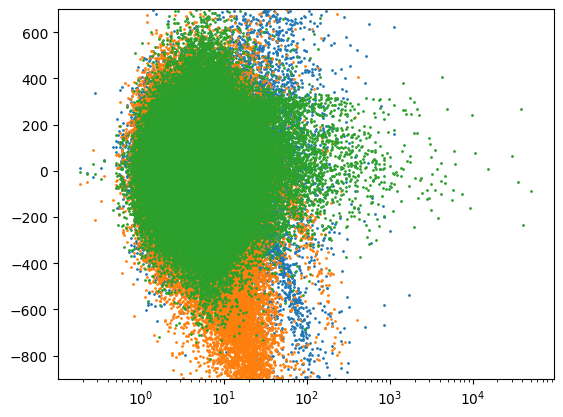

In [22]:
plt.scatter(r,vs_theta,s=1)
plt.scatter(r,vs_phi,s=1)
plt.scatter(r,vs_r,s=1)
plt.ylim(-900,700)
#plt.xlim(0,200)
plt.xscale('log')

In [33]:
import numpy as np
import matplotlib.pyplot as plt


r_valid     = R
V_r_valid   = v_R
V_th_valid  = v_phi
V_ph_valid  = v_z

# --- Define robust_sigma function (Tukey biweight estimator) ---
def robust_sigma(data, zero=False):
    """
    Resistant estimate of dispersion using Tukey biweight.
    For an uncontaminated distribution this is similar to std deviation.
    """
    y = np.array(data, dtype=float).ravel()
    if y.size == 0:
        return np.nan
    # Initial location
    if zero:
        y0 = 0.0
    else:
        y0 = np.median(y)
    dy = y - y0
    mad = np.median(np.abs(dy)) / 0.6745  # approximate to 1-sigma for normal dist
    # If MAD is zero, fall back to mean absolute dev
    if mad < 1e-20:
        mad = np.mean(np.abs(dy)) / 0.80
        if mad < 1e-20:
            return 0.0
    # Tukey biweight
    u = dy / (6.0 * mad)
    mask_u = np.abs(u) <= 1.0
    if mask_u.sum() < 3:
        # Not enough points in the core of distribution
        return np.nan
    u2 = u[mask_u]**2
    y_core = y[mask_u]
    numerator = np.sum((y_core - y0)**2 * (1 - u2)**4)
    den1 = np.sum((1 - u2) * (1 - 5.0 * u2))
    n = y.size
    sigma2 = n * numerator / (den1 * (den1 - 1))
    return np.sqrt(sigma2) if sigma2 > 0 else 0.0

# --- Bin the radial data (Freedman-Diaconis rule) ---
bin_edges = np.histogram_bin_edges(r_valid, bins='fd')
# Compute bin centers for plotting
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

# Initialize arrays for results
n_bins = len(bin_centers)
sigma_Vr   = np.full(n_bins, np.nan)
sigma_Vt   = np.full(n_bins, np.nan)
sigma_Vp   = np.full(n_bins, np.nan)
median_Vr  = np.full(n_bins, np.nan)
median_Vt  = np.full(n_bins, np.nan)
median_Vp  = np.full(n_bins, np.nan)

# Compute robust sigma and median in each radial bin
for i in range(n_bins):
    # Select points in current radial bin
    in_bin = (r_valid >= bin_edges[i]) & (r_valid < bin_edges[i+1])
    if not np.any(in_bin):
        continue
    Vr_bin = V_r_valid[in_bin]
    Vt_bin = V_th_valid[in_bin]
    Vp_bin = V_ph_valid[in_bin]
    # Compute medians (always possible if at least one point)
    median_Vr[i] = np.median(Vr_bin) if Vr_bin.size > 0 else np.nan
    median_Vt[i] = np.median(Vt_bin) if Vt_bin.size > 0 else np.nan
    median_Vp[i] = np.median(Vp_bin) if Vp_bin.size > 0 else np.nan
    # Compute robust sigmas only if enough points
    if Vr_bin.size >= 3:
        sigma_Vr[i] = robust_sigma(Vr_bin, zero=False)
    if Vt_bin.size >= 3:
        sigma_Vt[i] = robust_sigma(Vt_bin, zero=False)
    if Vp_bin.size >= 3:
        sigma_Vp[i] = robust_sigma(Vp_bin, zero=False)

# --- Plot the robust dispersion profiles ---
plt.figure(figsize=(6,4))
plt.plot(bin_centers, sigma_Vr, marker='o', linestyle='-', label=r'$\sigma(V_r)$')
plt.plot(bin_centers, sigma_Vt, marker='s', linestyle='-', label=r'$\sigma(V_\theta)$')
plt.plot(bin_centers, sigma_Vp, marker='^', linestyle='-', label=r'$\sigma(V_\phi)$')
plt.xlabel('Radius $r$')
plt.ylabel('Robust Dispersion (velocity)')
plt.legend()
plt.title('Robust Velocity Dispersions vs. Radius')
plt.ylim(0,500)
plt.xlim(0,200)
plt.tight_layout()

# --- Plot the median velocity profiles ---
plt.figure(figsize=(6,4))
plt.plot(bin_centers, median_Vr, marker='o', linestyle='-', label=r'$\mathrm{median}(V_r)$')
plt.plot(bin_centers, median_Vt, marker='s', linestyle='-', label=r'$\mathrm{median}(V_\theta)$')
plt.plot(bin_centers, median_Vp, marker='^', linestyle='-', label=r'$\mathrm{median}(V_\phi)$')
plt.xlabel('Radius $r$')
plt.ylabel('Median Velocity')
plt.legend()
plt.title('Median Velocity Components vs. Radius')
plt.xlim(0,200)
plt.tight_layout()

plt.show()


NameError: name 'v_R' is not defined

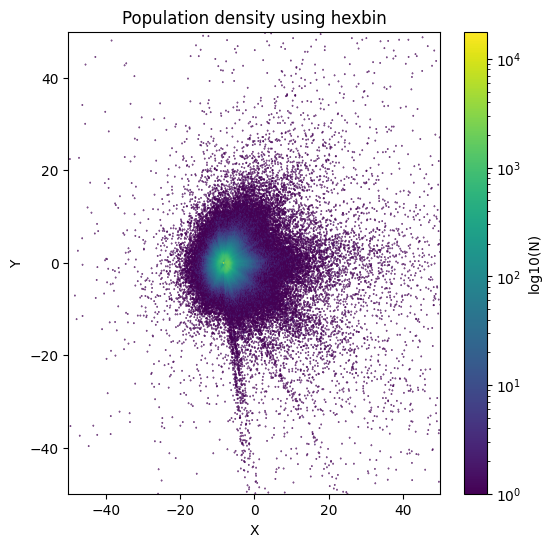

In [50]:
import matplotlib.pyplot as plt
k=50
plt.figure(figsize=(6, 6))
hb = plt.hexbin(X,Y, gridsize=1000, cmap='viridis', bins='log', extent=(-k, k, -k, k))
plt.colorbar(hb, label='log10(N)')
plt.xlim(-k,k)
plt.ylim(-k,k)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Population density using hexbin")
plt.show()


In [6]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

file_path=r"TRGB_Gaia_new-result.csv"
cep=pd.read_csv(file_path)
ra_array = np.array(cep['ra']) * u.degree
dec_array = np.array(cep['dec']) * u.degree
distance_array = (np.array(cep['parallax']) * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = np.array(cep['pmra']) * u.mas / u.yr
pm_dec_array = np.array(cep['pmdec']) * u.mas / u.yr
radial_velocity_array = np.array(cep['radial_velocity']) * u.km / u.s
l=np.array(cep['l']) * u.degree
b=np.array(cep['b']) * u.degree 




'''cep=np.loadtxt('GC.txt')
ra_array = cep[1:, 2]* u.degree
dec_array =cep[1:, 3] * u.degree
distance_array = (cep[1:, 1] * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = cep[1:, 5] * u.mas / u.yr
pm_dec_array = cep[1:, 6] * u.mas / u.yr
radial_velocity_array = cep[1:, 4] * u.km / u.s
l=cep[1:, 7] * u.degree
b=cep[1:, 8]* u.degree '''


# Constants
U_sun, V_sun, W_sun = 11.1* u.km / u.s, 12.24* u.km / u.s, 7.25* u.km / u.s  # Solar motion (km/s)
V0 = 229   * u.km / u.s  # Galactic rotation speed (km/s)
R0 = 8.1 * u.kpc

# Function to transform coordinates
def transform_to_galactocentric(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity,l,b):
    c = SkyCoord(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pm_ra_cosdec,
                 pm_dec=pm_dec, radial_velocity=radial_velocity)
    g = c.transform_to(Galactocentric(galcen_distance=8.1 * u.kpc,  # Default distance to Galactic Center
                                      z_sun=0.020 * u.kpc,  # Default Sun's height above the Galactic plane
                                      galcen_v_sun=[11.1,12.24, 7.25] * (u.km / u.s)))
    
    x, y, z = g.x.value, g.y.value, g.z.value
    vx, vy, vz = g.v_x.value, g.v_y.value, g.v_z.value
    d=distance
    # Cylindrical coordinates and velocities
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    vc_R = (x * vx + y * vy) / R
    vc_phi = (-y * vx + x * vy) / R
    vc_z = vz  # same

# Spherical coordinates and velocities
    r = np.sqrt(x**2 + y**2 + z**2)
    theta_s = np.arccos(z / r)
    vs_r = (x * vx + y * vy + z * vz) / r
    vs_theta = (x * z * vx + y * z * vy - (x**2 + y**2) * vz) / (r * np.sqrt(x**2 + y**2))
    vs_phi = (-y * vx + x * vy) / np.sqrt(x**2 + y**2)
    r=np.sqrt(R0**2 + d**2 - 2 * R0 * d * np.cos(b) * np.cos(l))
    v_gsr=radial_velocity + U_sun * np.cos(b) * np.cos(l) + \
           V_sun * np.cos(b) * np.sin(l) + \
           W_sun * np.sin(b) + V0 * np.cos(b) * np.sin(l)
    

# Xue paper : 
    # Cartesian coordinates
    X, Y, Z = x, y, z
    U, V, W = vx, vy, vz  # Cartesian velocities


    r = np.sqrt(X**2 + Y**2 + Z**2)
    phi = np.arctan2(Y, X)
    theta = np.pi/2 - np.arctan2(Z, np.sqrt(X**2 + Y**2))

    # Spherical velocities
    V_r = (U * np.cos(phi) + V * np.sin(phi)) * np.sin(theta) + W * np.cos(theta)
    V_theta = (U * np.cos(phi) + V * np.sin(phi)) * np.cos(theta) - W * np.sin(theta)
    V_phi = U * np.sin(phi) - V * np.cos(phi)    

    v_c=(R/R0)*((v_gsr/(np.sin(l)*np.cos(b))+V0))
    

    return X,Y,Z,U,V,W,R, phi, z, vc_R, vc_phi, vc_z,vs_r,vs_theta,vs_phi, np.abs(z),r,v_gsr,v_c ,V_r,V_theta,V_phi
#plt.scatter((transform_to_galactocentric(ra_array,dec_array,distance_array,pm_ra_cosdec_array,pm_dec_array,radial_velocity_array)[0]),(transform_to_galactocentric(ra_array,dec_array,distance_array,pm_ra_cosdec_array,pm_dec_array,radial_velocity_array)[3]),s=1)
# Run the transformation
X, Y, Z, U, V, W, R, phi, z, vc_R, vc_phi, vc_z, vs_r, vs_theta, vs_phi, abs_z, r, v_gsr, v_c, V_r, V_theta, V_phi = \
    transform_to_galactocentric(ra_array, dec_array, distance_array,
                                 pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)

import matplotlib.pyplot as plt



# ---------------------------------------
# Step 1: Define the mask to remove stars
# Example: Remove stars with |Z| > 5 kpc
# ---------------------------------------
mask_remove =z<-3
mask_keep = ~mask_remove


In [18]:
V_r_valid

array([  38.61899063,  -73.55848783,   99.97945212, ..., -104.49330676,
        -92.50103218,    0.40682779])

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

r_valid     = r[mask_keep]
V_r_valid   = V_r[mask_keep]
V_th_valid  = V_theta[mask_keep]
V_ph_valid  = V_phi[mask_keep]

# Define radial bins
num_bins = 15
bins = np.logspace(np.log10(np.min(r_valid)), np.log10(np.max(r_valid)), num_bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Compute statistics
sigma_r, _, _ = binned_statistic(r_valid, V_r_valid, statistic='std', bins=bins)
sigma_th, _, _ = binned_statistic(r_valid, V_th_valid, statistic='std', bins=bins)
sigma_ph, _, _ = binned_statistic(r_valid, V_ph_valid, statistic='std', bins=bins)

N_bin, _, _ = binned_statistic(r_valid, V_r_valid, statistic='count', bins=bins)

# Convert to float to avoid integer NaN issues
N_bin = N_bin.astype(float)

# Mask bins with 0 count
valid_mask = N_bin > 0

# Compute errors with masking
sigma_r_err  = np.full_like(sigma_r, np.nan)
sigma_th_err = np.full_like(sigma_th, np.nan)
sigma_ph_err = np.full_like(sigma_ph, np.nan)

sigma_r_err[valid_mask]  = sigma_r[valid_mask] / np.sqrt(2 * N_bin[valid_mask])
sigma_th_err[valid_mask] = sigma_th[valid_mask] / np.sqrt(2 * N_bin[valid_mask])
sigma_ph_err[valid_mask] = sigma_ph[valid_mask] / np.sqrt(2 * N_bin[valid_mask])

# Compute beta and propagate error
beta = np.full_like(sigma_r, np.nan)
beta[valid_mask] = 1 - (sigma_th[valid_mask]**2 + sigma_ph[valid_mask]**2) / (2 * sigma_r[valid_mask]**2)

beta_err = np.full_like(beta, np.nan)
if np.any(valid_mask):
    sr = sigma_r[valid_mask]
    st = sigma_th[valid_mask]
    sp = sigma_ph[valid_mask]
    sr_err = sigma_r_err[valid_mask]
    st_err = sigma_th_err[valid_mask]
    sp_err = sigma_ph_err[valid_mask]

    d_beta_d_sr  = (st**2 + sp**2) / sr**3
    d_beta_d_st = -st / sr**2
    d_beta_d_sp = -sp / sr**2

    beta_err[valid_mask] = np.sqrt(
        (d_beta_d_sr * sr_err)**2 +
        (d_beta_d_st * st_err)**2 +
        (d_beta_d_sp * sp_err)**2
    )

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Dispersion plot
axs[0].errorbar(bin_centers[valid_mask], sigma_r[valid_mask], yerr=sigma_r_err[valid_mask], fmt='o', label=r'$\sigma_r$', capsize=3)
axs[0].errorbar(bin_centers[valid_mask], sigma_th[valid_mask], yerr=sigma_th_err[valid_mask], fmt='s', label=r'$\sigma_\theta$', capsize=3)
axs[0].errorbar(bin_centers[valid_mask], sigma_ph[valid_mask], yerr=sigma_ph_err[valid_mask], fmt='^', label=r'$\sigma_\phi$', capsize=3)
axs[0].set_ylabel('Velocity Dispersion [km/s]')
axs[0].set_xscale('log')
axs[0].grid(True)
axs[0].legend()

# Beta plot
axs[1].errorbar(bin_centers[valid_mask], beta[valid_mask], yerr=beta_err[valid_mask], fmt='o', color='black', capsize=3)
axs[1].set_xlabel('Galactocentric Radius [kpc]')
axs[1].set_ylabel(r'$\beta$')
axs[1].set_xscale('log')
axs[1].grid(True)

plt.tight_layout()
plt.show()


ValueError: cannot convert float NaN to integer

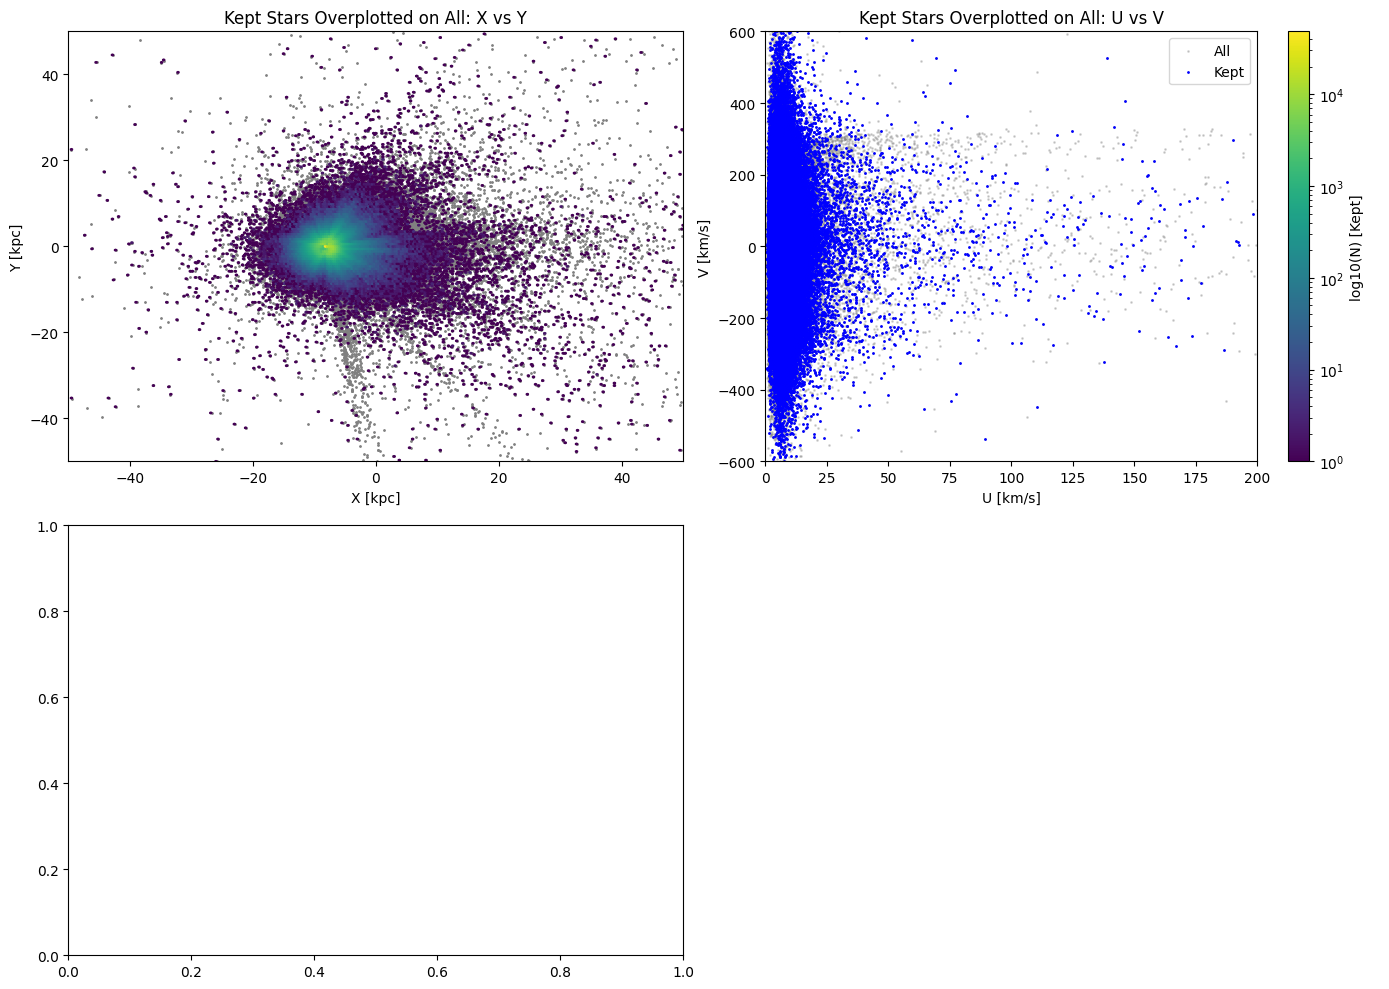

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

# Run the transformation
X, Y, Z, U, V, W, R, phi, z, vc_R, vc_phi, vc_z, vs_r, vs_theta, vs_phi, abs_z, r, v_gsr, v_c, V_r, V_theta, V_phi = \
    transform_to_galactocentric(ra_array, dec_array, distance_array,
                                 pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)

# ---------------------------------------
# Step 1: Define the mask to remove stars
# Example: Remove stars with |Z| > 5 kpc
# ---------------------------------------
mask_remove = z <0
mask_keep = ~mask_remove

# ---------------------------------------
# Step 2: Plotting
# ---------------------------------------
k = 50  # axis limits

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from galpy.potential import MWPotential2014, evaluatePotentials
import astropy.units as u

V_r = vs_r * u.km/u.s
V_theta = vs_theta * u.km/u.s
V_phi = vs_phi * u.km/u.s
Z = z * u.kpc
r_gc = r * u.kpc

V_tot2 = V_r**2 + V_theta**2 + V_phi**2
V_tan = np.sqrt(V_theta**2 + V_phi**2)
L = (r_gc * V_tan).to(u.kpc * u.km/u.s)

R_galpy = (r_gc / (8.0 * u.kpc)).decompose().value
Z_galpy = (Z / (1.0 * u.kpc)).decompose().value
phi = evaluatePotentials(MWPotential2014, R_galpy, Z_galpy) * u.km**2 / u.s**2
E = phi + 0.5 * V_tot2
fig, axs = plt.subplots(2, 2, figsize=(14, 10))



# ---- Upper Right: Hexbin of all (gray) + kept (color) ----
axs[0, 0].scatter(X,Y,color='gray',s=1,alpha=1)
hb_kept = axs[0, 0].hexbin(X[mask_keep], Y[mask_keep], gridsize=300, cmap='viridis', bins='log', extent=(-k, k, -k, k))
axs[0, 0].set_title("Kept Stars Overplotted on All: X vs Y")
axs[0, 0].set_xlabel("X [kpc]")
axs[0, 0].set_ylabel("Y [kpc]")
axs[0, 0].set_xlim(-k, k)
axs[0, 0].set_ylim(-k, k)
fig.colorbar(hb_kept, ax=axs[0, 1], label='log10(N) [Kept]')



# ---- Lower Right: Scatter of all (gray) + kept (blue) ----
axs[0, 1].scatter(r, V_r, s=1, color='gray', alpha=0.3, label='All')
axs[0, 1].scatter(r[mask_keep], V_r[mask_keep], s=1, color='blue', label='Kept')
axs[0, 1].set_title("Kept Stars Overplotted on All: U vs V")
axs[0, 1].set_xlabel("U [km/s]")
axs[0, 1].set_ylabel("V [km/s]")
axs[0, 1].set_xlim(0, 200)
axs[0, 1].set_ylim(-600, 600)
axs[0, 1].legend()

# # --- Lower Left: E vs L plot ---
# axs[1, 0].scatter(E ,L, s=1, color='gray', alpha=0.1, label='All')
# axs[1, 0].scatter(E[mask_keep].value, L[mask_keep].value, s=1, color='blue', label='Kept')
# axs[1, 0].set_xlabel(r'$E$ [km$^2$/s$^2$]')
# axs[1, 0].set_ylabel(r'$L$ [kpc km/s]')
# axs[1, 0].set_title("Angular Momentum vs Energy")
# axs[1, 0].set_xlim(200000, 0)
# axs[1, 0].set_ylim(0, 10000)
# axs[1, 0].legend()

# --- Optional: Leave lower right blank or use it for something else ---
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()



(-500.0, 500.0)

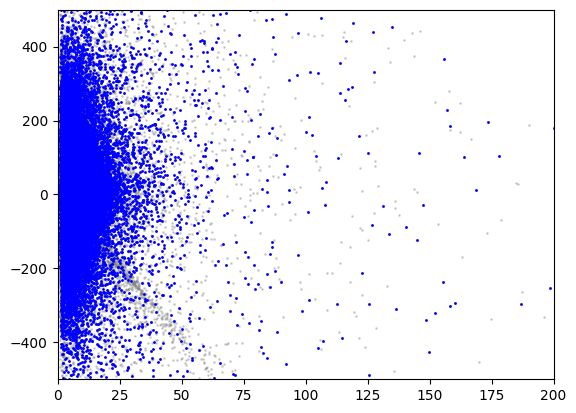

In [18]:

plt.scatter(r, V_theta, s=1, color='gray', alpha=0.3, label='All')
plt.scatter(r[mask_keep], V_theta[mask_keep], s=1, color='blue', label='Kept')
plt.xlim(0,200)
plt.ylim(-500,500)

NameError: name 'mask_keep' is not defined

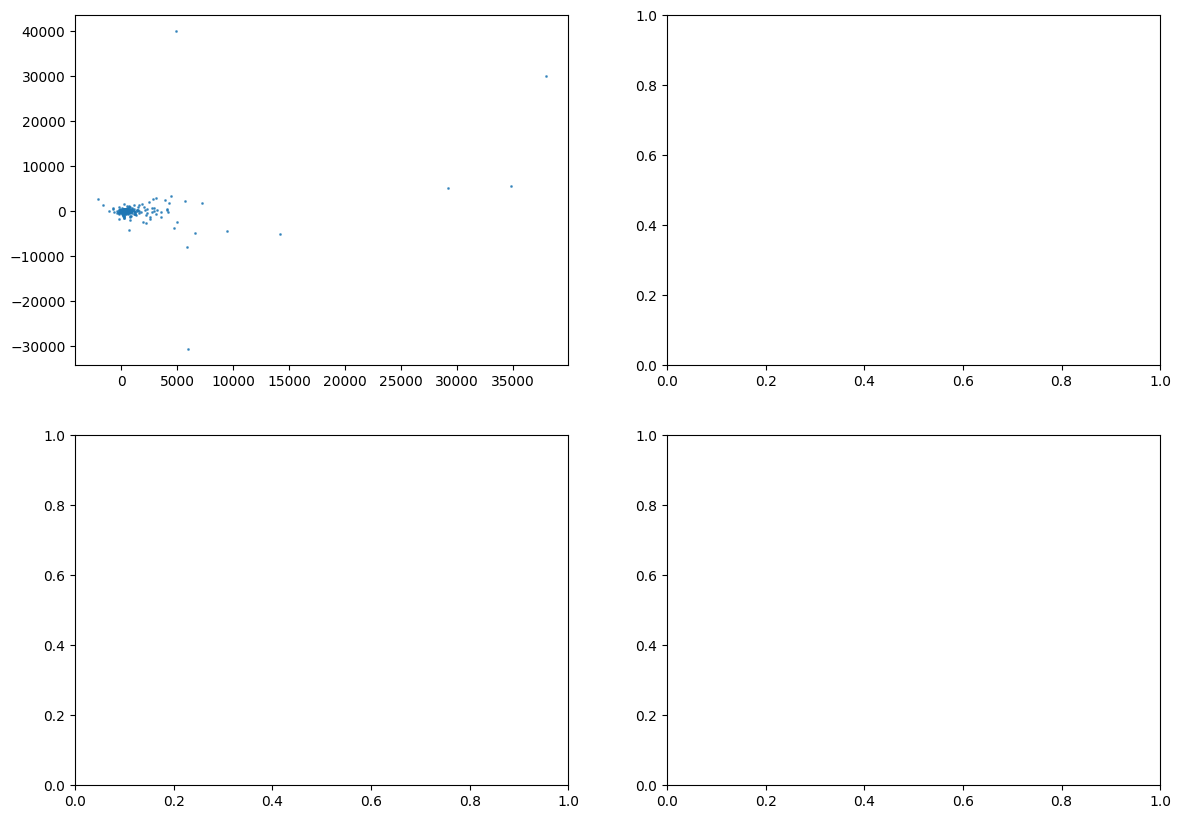

In [5]:


import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))



# ---- Upper Right: Hexbin of all (gray) + kept (color) ----
axs[0, 0].scatter(X,Y,s=1,alpha=0.7)
hb_kept = axs[0, 0].hexbin(X[mask_keep], Y[mask_keep], gridsize=300, cmap='viridis', bins='log', extent=(-k, k, -k, k))
axs[0, 0].set_title("Kept Stars Overplotted on All: X vs Y")
axs[0, 0].set_xlabel("X [kpc]")
axs[0, 0].set_ylabel("Y [kpc]")
axs[0, 0].set_xlim(-k, k)
axs[0, 0].set_ylim(-k, k)
fig.colorbar(hb_kept, ax=axs[0, 1], label='log10(N) [Kept]')



# ---- Lower Right: Scatter of all (gray) + kept (blue) ----
axs[0, 1].scatter(r, V_theta, s=1, color='gray', alpha=0.3, label='All')
axs[0, 1].scatter(r[mask_keep], V_theta[mask_keep], s=1, color='blue', label='Kept')
axs[0, 1].set_title("Kept Stars Overplotted on All: U vs V")
axs[0, 1].set_xlabel("U [km/s]")
axs[0, 1].set_ylabel("V [km/s]")
axs[0, 1].set_xlim(0, 200)
axs[0, 1].set_ylim(-600, 600)
axs[0, 1].legend()

plt.tight_layout()
plt.show()




(0.0, 200.0)

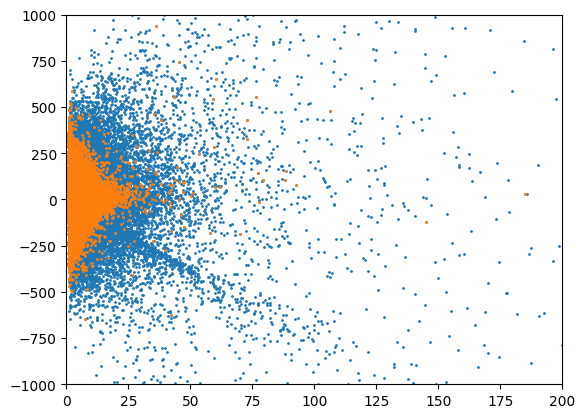

In [44]:
plt.scatter(r,V_theta,s=1)
plt.scatter(r[mask_keep],V_theta[mask_keep],s=1)
plt.ylim(-1000,1000)
plt.xlim(0,200)

In [38]:
import sys
!{sys.executable} -m pip install galpy

You should consider upgrading via the 'c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


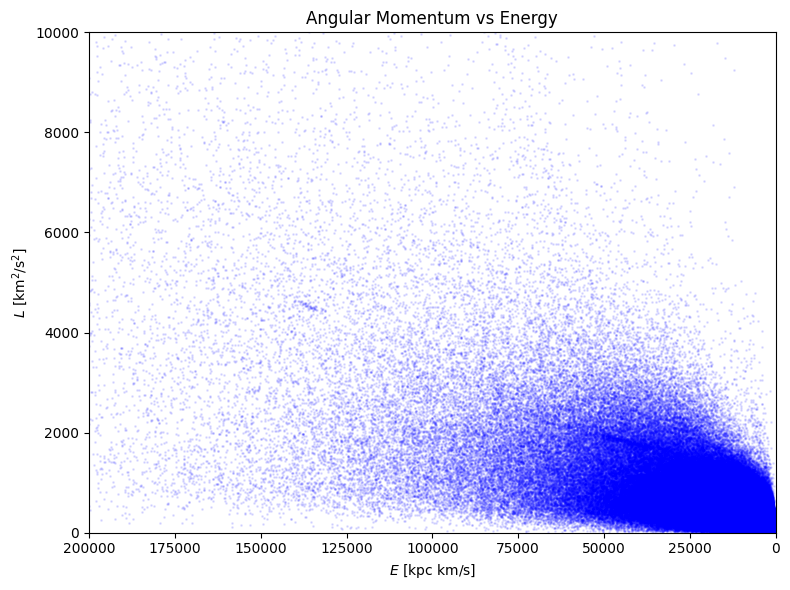

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from galpy.potential import MWPotential2014, evaluatePotentials
import astropy.units as u

# 1. Inputs you already have (assumed numpy arrays in astropy units)
# V_r, V_theta, V_phi in km/s
# Z in kpc, r_gc in kpc

# Example arrays (replace with your real data)
V_r = vs_r * u.km/u.s
V_theta = vs_theta * u.km/u.s
V_phi =vs_phi * u.km/u.s
Z = z* u.kpc
r_gc = r * u.kpc

# 2. Compute total velocity squared
V_tot2 = V_r**2 + V_theta**2 + V_phi**2
V_tan = np.sqrt(V_theta**2 + V_phi**2)

# 3. Compute angular momentum
L = (r_gc * V_tan).to(u.kpc * u.km/u.s)

# 4. Compute gravitational potential Φ(R, Z)
# r_gc must be dimensionless in galpy units (R0=8 kpc, Z0=1 kpc)
R_galpy = (r_gc / 8.0 / u.kpc).decompose().value
Z_galpy = (Z / 1.0 / u.kpc).decompose().value
phi = evaluatePotentials(MWPotential2014, R_galpy, Z_galpy) * u.km**2 / u.s**2

# 5. Compute energy
E = phi + 0.5 * V_tot2  # Already in km^2/s^2

# Optional: Convert L to physical units like kpc.km/s
#           Convert E to 10^4 km^2/s^2 or similar for better scaling

# 6. Plot
plt.figure(figsize=(8, 6))
plt.scatter(E, L, s=1, alpha=0.1, c='blue')
plt.xlabel(r'$E$ [kpc km/s]')
plt.ylabel(r'$L$ [km$^2$/s$^2$]')
plt.title('Angular Momentum vs Energy')
plt.xlim(200000,0)
plt.ylim(0,10000)
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Transform coordinates
result = transform_to_galactocentric(
    ra_array, dec_array, distance_array, 
    pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b
)

R, phi, z, v_R, v_phi, v_z, abs_z, r, v_gsr, v_c = result

# Stack into array and filter out NaNs and infs
data = np.vstack([R, z, v_phi])
mask = np.all(np.isfinite(data), axis=0)
data_clean = data[:, mask]

# Compute KDE
kde = gaussian_kde(data_clean)(data_clean)

# 3D Scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_clean[0], data_clean[1], data_clean[2], c=kde, cmap='viridis', s=3)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_zlabel(r"$v_\phi$ [km/s]")
fig.colorbar(sc, ax=ax, label='Phase-space density')
plt.title("3D Phase-Space: (R, z, $v_\\phi$)")
plt.tight_layout()
plt.show()


ValueError: too many values to unpack (expected 10)

(-1500.0, 1500.0)

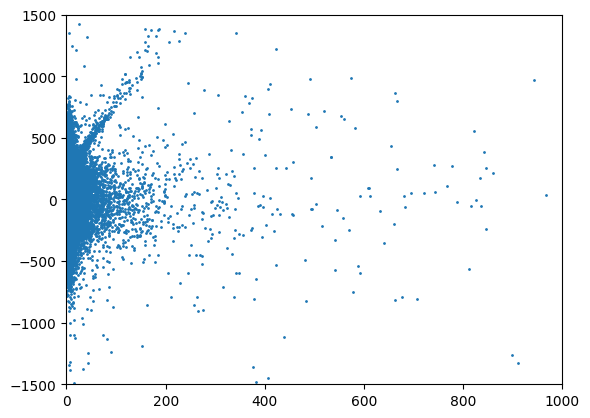

In [ ]:

plt.scatter([0],transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[3],s=1)
plt.xlim(0,1000)transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)

plt.ylim(-1500,1500)

In [4]:
transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[7]


array([8.50732089, 7.89134722, 7.59326873, ..., 7.31926807, 7.8486437 ,
       4.49719665])

(-500.0, 500.0)

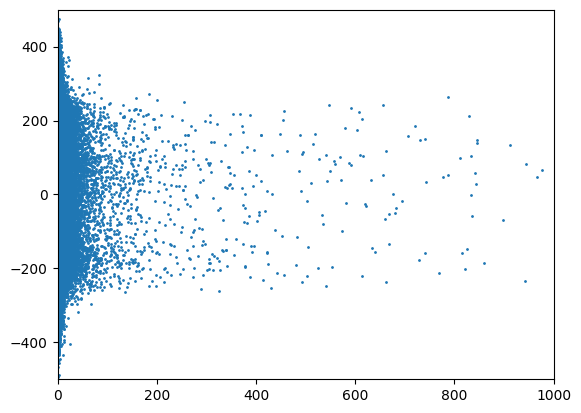

In [5]:
plt.scatter(transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[0],transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[8],s=1)
plt.xlim(0,1000)

plt.ylim(-500,500)

     Bin Center       Mean X     Mean Y       Std Y  Num Points
0     10.705882     9.178376   4.807969  150.488972    982427.0
1     16.117647    14.999222  -5.154010  106.253170     11456.0
2     21.529412    21.111449   2.959664  133.535391      1857.0
3     26.941176    26.753169  -3.016215  139.718887       939.0
4     32.352941    32.224666   3.869715  137.177737       605.0
5     37.764706    37.683492  -6.230890  138.734534       397.0
6     43.176471    43.115160   1.239388  139.471192       289.0
7     48.588235    48.519943  -4.479651  140.441634       224.0
8     54.000000    53.929697  -6.096093  133.015675       157.0
9     59.411765    59.383845 -13.102286  139.849408       150.0
10    64.823529    64.786785 -14.247924  141.566356        96.0
11    70.235294    70.439531   0.092494  137.174219        90.0
12    75.647059    75.376701 -20.761379  127.970720        82.0
13    81.058824    80.879435 -13.181584  140.503313        61.0
14    86.470588    86.228879   4.868103 

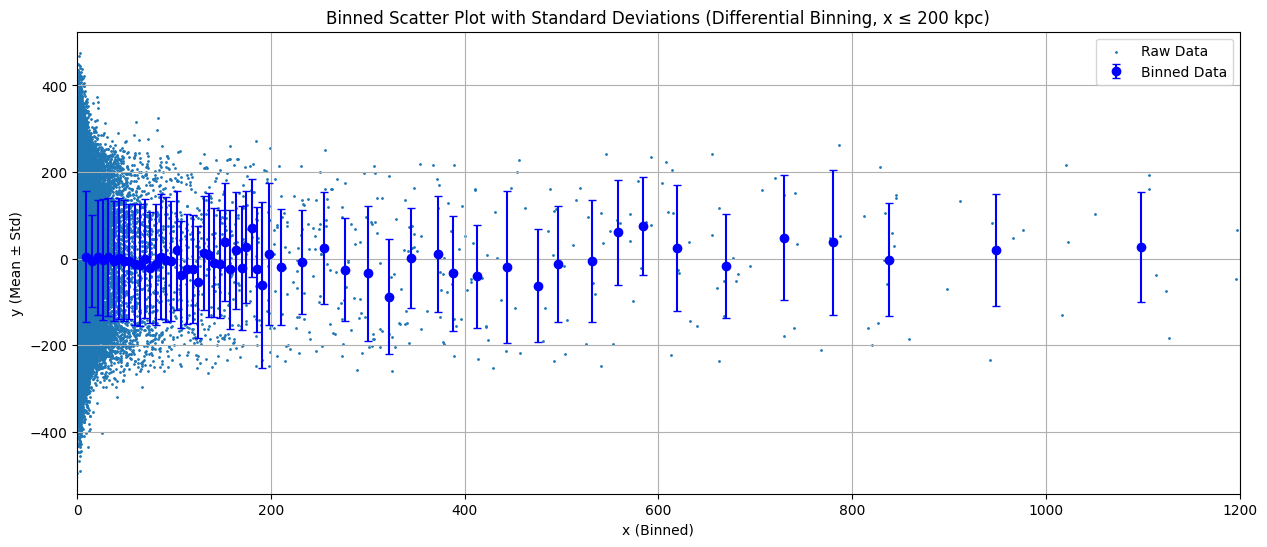

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# Example data
np.random.seed(42)  # For reproducibility
x = (transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[0])
y = (transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[8])

# Remove NaN values
valid = ~np.isnan(x) & ~np.isnan(y)
x_clean = x[valid]
y_clean = y[valid]

# Restrict data to x <= 200 kpc
valid_range = x_clean <= 1200
x_clean = x_clean[valid_range]
y_clean = y_clean[valid_range]

# Define custom bin edges for differential binning
custom_bin_edges = np.concatenate([
    np.linspace(8,100,18),  # 10 bins in range [min(x), 50]
    np.linspace(100,150, 10)[1:],
    np.linspace(150,200, 10)[1:], 
    np.linspace(200,400, 10)[1:], 
    np.linspace(400,600, 8)[1:], 
    np.linspace(600,800, 5)[1:], 
    np.linspace(800,1000, 3)[1:],  
    np.linspace(1000,1200, 2)[1:],                                                                                                                                    
      # 2 bins in range (150, max(x)]
])
bin_centers = 0.5 * (custom_bin_edges[:-1] + custom_bin_edges[1:])

# Compute statistics
mean_x, _, _ = binned_statistic(x_clean, x_clean, statistic='mean', bins=custom_bin_edges)
mean_y, _, _ = binned_statistic(x_clean, y_clean, statistic='mean', bins=custom_bin_edges)
std_y, _, _ = binned_statistic(x_clean, y_clean, statistic='std', bins=custom_bin_edges)
n_points, _, _ = binned_statistic(x_clean, y_clean, statistic='count', bins=custom_bin_edges)

# Create DataFrame
binned_data = pd.DataFrame({
    'Bin Center': bin_centers,
    'Mean X': mean_x,
    'Mean Y': mean_y,
    'Std Y': std_y,
    'Num Points': n_points
})

# Drop rows with NaN values (e.g., empty bins)
binned_data = binned_data.dropna()
binned_data_restricted = binned_data[binned_data['Bin Center'] <= 1200]
# Display DataFrame
print(binned_data_restricted)





# Plotting
plt.figure(figsize=(15, 6))
plt.scatter(x_clean, y_clean, s=1, label='Raw Data')
plt.errorbar(binned_data['Mean X'], binned_data['Mean Y'], 
             yerr=binned_data['Std Y'], fmt='o', label='Binned Data', 
             color='blue', capsize=3)
plt.xlim(0, 1200)
plt.xlabel('x (Binned)')
plt.ylabel('y (Mean ± Std)')
plt.title('Binned Scatter Plot with Standard Deviations (Differential Binning, x ≤ 200 kpc)')
plt.grid()
plt.legend()
plt.show()


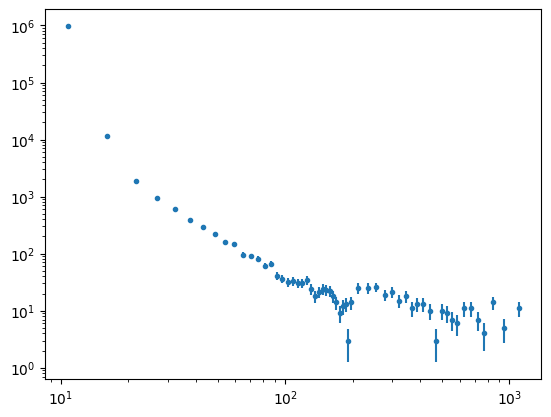

In [7]:
len(x_clean)
yerr=np.sqrt(n_points)
plt.errorbar(bin_centers,n_points,yerr=np.sqrt(n_points),fmt='.')
plt.xscale("log")
plt.yscale("log")

# Combine the arrays into a single 2D array
data = np.column_stack((bin_centers, n_points, yerr))

# Save the data to a text file
#np.savetxt('trgb_mpc_GAIAtxt', data, fmt='%10.5f')


Fitted parameters:
a = 0.000000021
b = -10.857586242


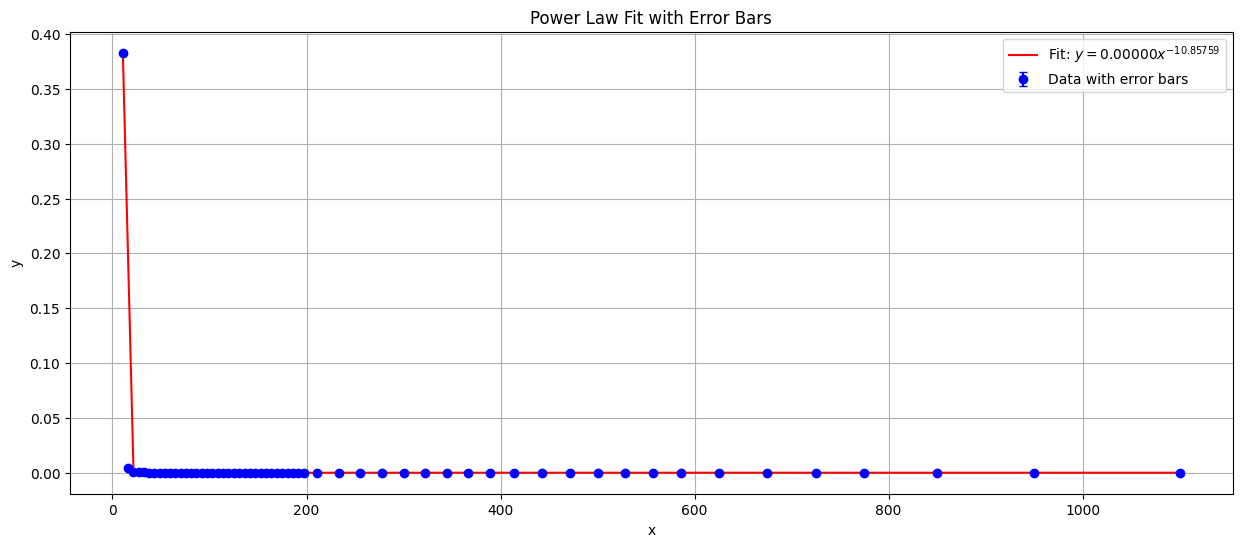

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data setup (replace this with your actual data)
np.random.seed(42)
n_tr = binned_data_restricted['Num Points'] / len(x_clean)  # Replace with your data
s_gsr = binned_data_restricted['Std Y']                    # Replace with your data
r_bin = binned_data_restricted['Bin Center']               # Replace with your data

# Define the power-law function
def power_law(x, a, b):
    return a * (x/50)**b

# Fit the power law to the data
popt, pcov = curve_fit(power_law, r_bin, n_tr, p0=(1, 1))  # Initial guesses for a and b
fitted_a_n, fitted_b_n = popt

# Generate fitted curve
x_fit = np.linspace(min(r_bin), max(r_bin), 100)
y_fit = power_law(x_fit, fitted_a_n, fitted_b_n)

# Calculate error bars (sqrt of n_tr)
error_bars = np.sqrt(n_tr/len(x_clean))

# Print fitted parameters
print(f"Fitted parameters:")
print(f"a = {fitted_a_n:.9f}")
print(f"b = {fitted_b_n:.9f}")

# Plot the data with error bars and the fitted curve
plt.figure(figsize=(15, 6))
plt.errorbar(r_bin, n_tr, yerr=error_bars, fmt='o', label='Data with error bars', color='blue', capsize=3)
plt.plot(x_fit, y_fit, label=f'Fit: $y = {fitted_a_n:.5f} x^{{{fitted_b_n:.5f}}}$', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Power Law Fit with Error Bars')
plt.legend()
plt.grid()
#plt.ylim(0,0.05)
plt.show()


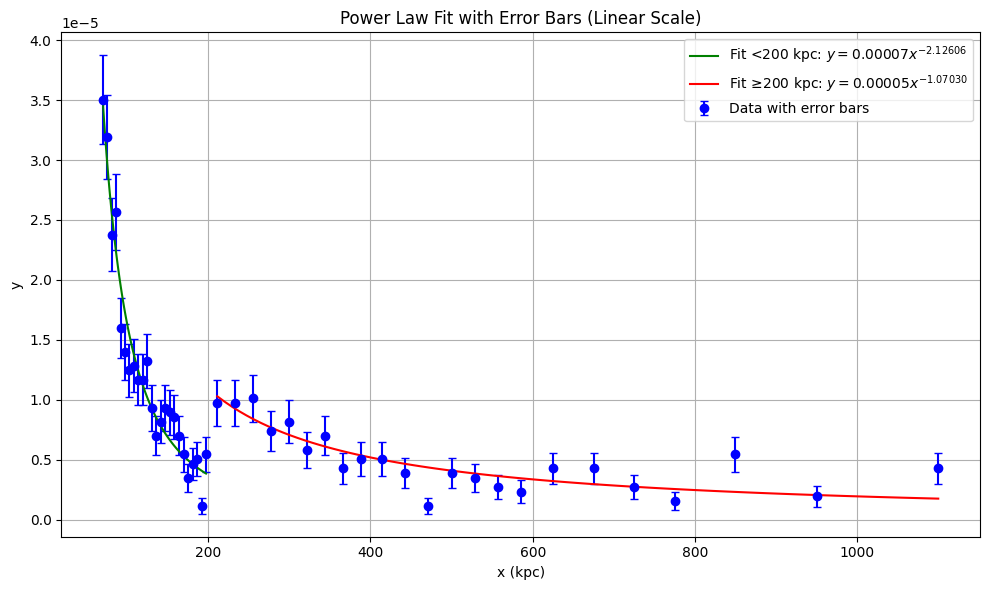

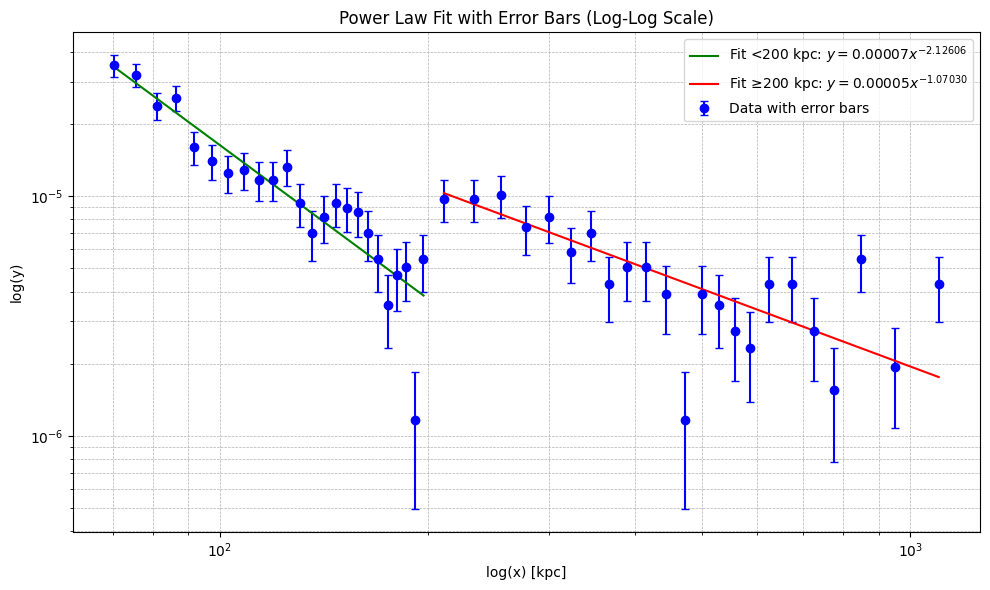

Fitted parameters:
< 200 kpc:     a = 0.000071212,     b = -2.126057674
≥ 200 kpc:     a = 0.000048091,     b = -1.070299538


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data setup (replace this with your actual data)
np.random.seed(42)
n_tr = binned_data_restricted['Num Points'] / len(x_clean)  # Replace with your data
s_gsr = binned_data_restricted['Std Y']                    # Replace with your data
r_bin = binned_data_restricted['Bin Center']               # Replace with your data

# Define the power-law function
def power_law(x, a, b):
    return a * (x / 50)**b

# Filter data for x >= 70
valid_mask = r_bin >= 70
r_bin_valid = r_bin[valid_mask]
n_tr_valid = n_tr[valid_mask]

# Create masks for two ranges
mask_low = (r_bin_valid < 200)
mask_high = (r_bin_valid >= 200)

# Split data
r_bin_low = r_bin_valid[mask_low]
n_tr_low = n_tr_valid[mask_low]
r_bin_high = r_bin_valid[mask_high]
n_tr_high = n_tr_valid[mask_high]

# Fit power-law to low range (<200)
popt_low, _ = curve_fit(power_law, r_bin_low, n_tr_low, p0=(1, 1))
a_low, b_low = popt_low
x_fit_low = np.linspace(min(r_bin_low), max(r_bin_low), 100)
y_fit_low = power_law(x_fit_low, a_low, b_low)

# Fit power-law to high range (>=200)
popt_high, _ = curve_fit(power_law, r_bin_high, n_tr_high, p0=(1, 1))
a_high, b_high = popt_high
x_fit_high = np.linspace(min(r_bin_high), max(r_bin_high), 100)
y_fit_high = power_law(x_fit_high, a_high, b_high)

# Calculate error bars
error_bars = np.sqrt(n_tr_valid / len(x_clean))

# Plotting (linear scale)
plt.figure(figsize=(10, 6))
plt.errorbar(r_bin_valid, n_tr_valid, yerr=error_bars, fmt='o', label='Data with error bars', color='blue', capsize=3)
plt.plot(x_fit_low, y_fit_low, label=f'Fit <200 kpc: $y = {a_low:.5f} x^{{{b_low:.5f}}}$', color='green')
plt.plot(x_fit_high, y_fit_high, label=f'Fit ≥200 kpc: $y = {a_high:.5f} x^{{{b_high:.5f}}}$', color='red')
plt.xlabel('x (kpc)')
plt.ylabel('y')
plt.title('Power Law Fit with Error Bars (Linear Scale)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plotting (log-log scale)
plt.figure(figsize=(10, 6))
plt.errorbar(r_bin_valid, n_tr_valid, yerr=error_bars, fmt='o', label='Data with error bars', color='blue', capsize=3)
plt.plot(x_fit_low, y_fit_low, label=f'Fit <200 kpc: $y = {a_low:.5f} x^{{{b_low:.5f}}}$', color='green')
plt.plot(x_fit_high, y_fit_high, label=f'Fit ≥200 kpc: $y = {a_high:.5f} x^{{{b_high:.5f}}}$', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log(x) [kpc]')
plt.ylabel('log(y)')
plt.title('Power Law Fit with Error Bars (Log-Log Scale)')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Print fitted parameters
print("Fitted parameters:")
print(f"< 200 kpc:     a = {a_low:.9f},     b = {b_low:.9f}")
print(f"≥ 200 kpc:     a = {a_high:.9f},     b = {b_high:.9f}")


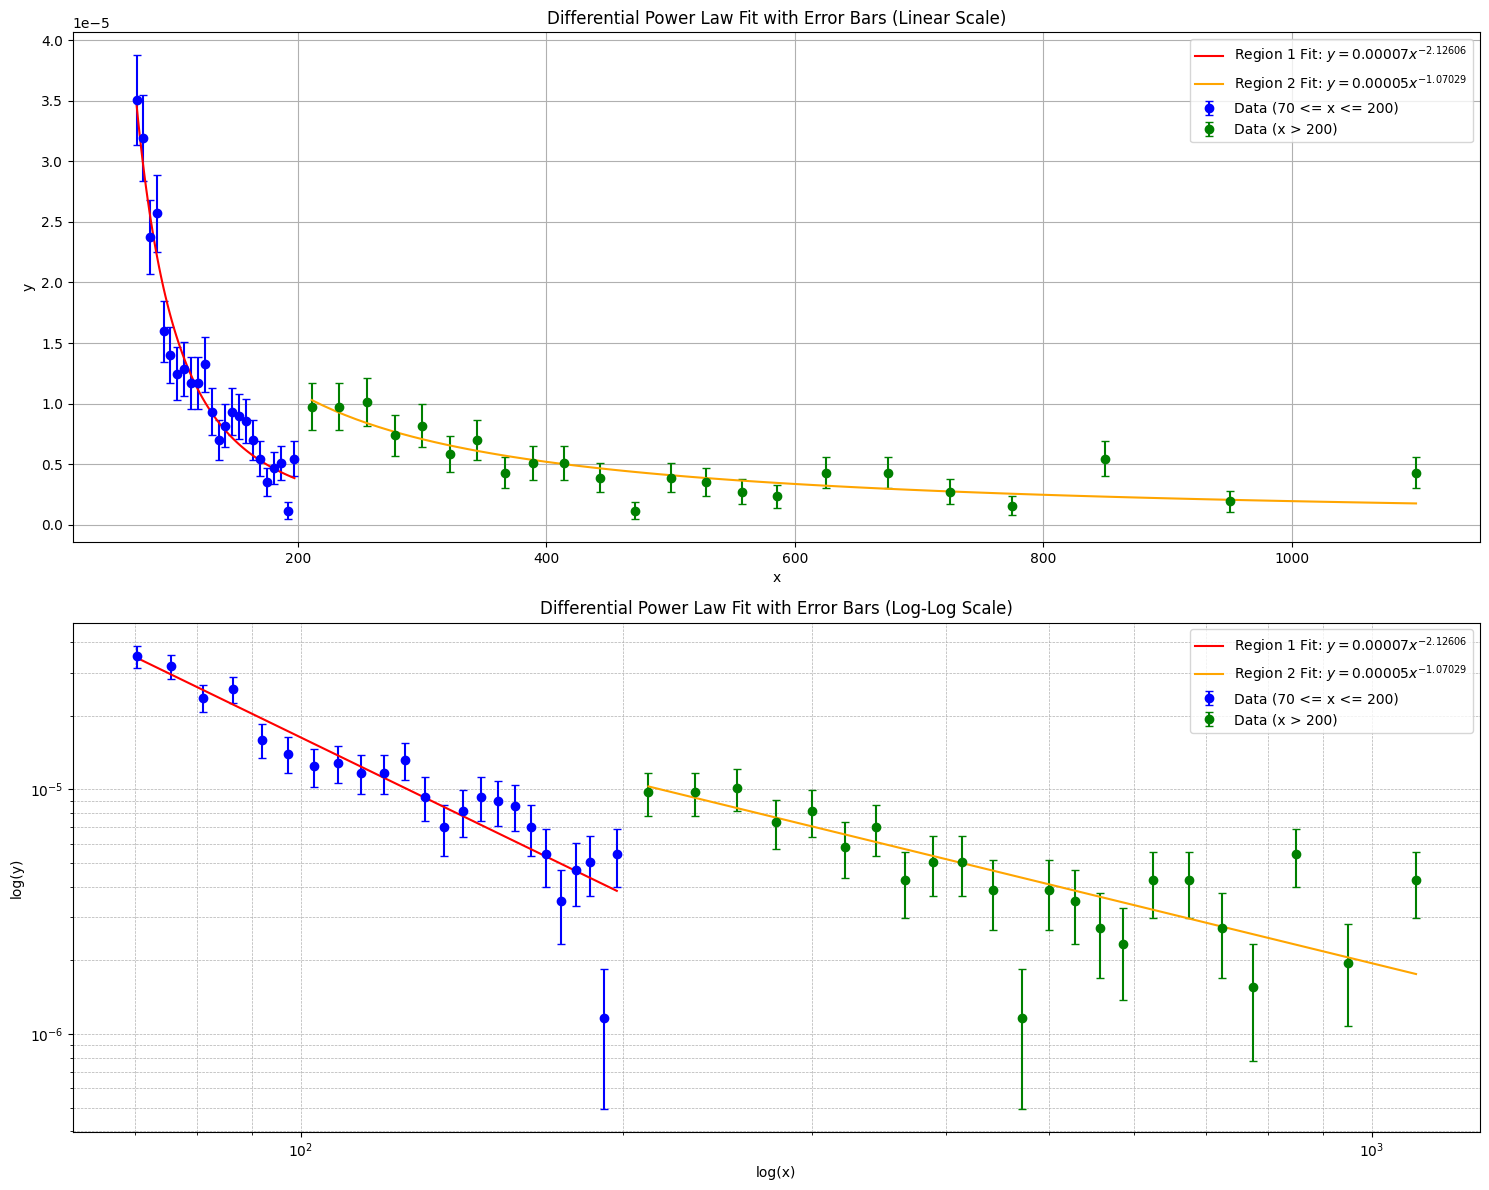

Region 1 (70 <= x <= 200) Fit:
a = 0.000071212
b = -2.126055848

Region 2 (x > 200) Fit:
a = 0.000048091
b = -1.070294596


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data setup (replace this with your actual data)
np.random.seed(42)
n_tr = binned_data_restricted['Num Points'] / len(x_clean)  # Replace with your data
s_gsr = binned_data_restricted['Std Y']                    # Replace with your data
r_bin = binned_data_restricted['Bin Center']               # Replace with your data

# Filter data for x >= 70
filter_mask = r_bin >= 70
r_bin_filtered = r_bin[filter_mask]
n_tr_filtered = n_tr[filter_mask]

# Define the power-law function
def power_law(x, a, b):
    return a * (x/50)**b

# ---- First fit: 70 <= r_bin <= 200 ----
mask_region1 = (r_bin_filtered >= 70) & (r_bin_filtered <= 200)
r1 = r_bin_filtered[mask_region1]
n1 = n_tr_filtered[mask_region1]

popt1, pcov1 = curve_fit(power_law, r1, n1, p0=(1, -1))
fitted_a1, fitted_b1 = popt1

x_fit1 = np.linspace(min(r1), max(r1), 100)
y_fit1 = power_law(x_fit1, fitted_a1, fitted_b1)

# ---- Second fit: r_bin > 200 ----
mask_region2 = r_bin_filtered > 200
r2 = r_bin_filtered[mask_region2]
n2 = n_tr_filtered[mask_region2]

popt2, pcov2 = curve_fit(power_law, r2, n2, p0=(1, -1))
fitted_a2, fitted_b2 = popt2

x_fit2 = np.linspace(min(r2), max(r2), 100)
y_fit2 = power_law(x_fit2, fitted_a2, fitted_b2)

# Error bars
error_bars1 = np.sqrt(n1 / len(x_clean))
error_bars2 = np.sqrt(n2 / len(x_clean))

# ---- Plotting ----
plt.figure(figsize=(15, 12))

# Linear Scale plot
plt.subplot(2, 1, 1)
plt.errorbar(r1, n1, yerr=error_bars1, fmt='o', label='Data (70 <= x <= 200)', color='blue', capsize=3)
plt.errorbar(r2, n2, yerr=error_bars2, fmt='o', label='Data (x > 200)', color='green', capsize=3)
plt.plot(x_fit1, y_fit1, label=f'Region 1 Fit: $y = {fitted_a1:.5f} x^{{{fitted_b1:.5f}}}$', color='red')
plt.plot(x_fit2, y_fit2, label=f'Region 2 Fit: $y = {fitted_a2:.5f} x^{{{fitted_b2:.5f}}}$', color='orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differential Power Law Fit with Error Bars (Linear Scale)')
plt.legend()
plt.grid()

# Log-log plot
plt.subplot(2, 1, 2)
plt.errorbar(r1, n1, yerr=error_bars1, fmt='o', label='Data (70 <= x <= 200)', color='blue', capsize=3)
plt.errorbar(r2, n2, yerr=error_bars2, fmt='o', label='Data (x > 200)', color='green', capsize=3)
plt.plot(x_fit1, y_fit1, label=f'Region 1 Fit: $y = {fitted_a1:.5f} x^{{{fitted_b1:.5f}}}$', color='red')
plt.plot(x_fit2, y_fit2, label=f'Region 2 Fit: $y = {fitted_a2:.5f} x^{{{fitted_b2:.5f}}}$', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log(x)')
plt.ylabel('log(y)')
plt.title('Differential Power Law Fit with Error Bars (Log-Log Scale)')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# ---- Print fitted parameters ----
print("Region 1 (70 <= x <= 200) Fit:")
print(f"a = {fitted_a1:.9f}")
print(f"b = {fitted_b1:.9f}")

print("\nRegion 2 (x > 200) Fit:")
print(f"a = {fitted_a2:.9f}")
print(f"b = {fitted_b2:.9f}")


Fitted parameters:
a = 135.983
b = -0.002


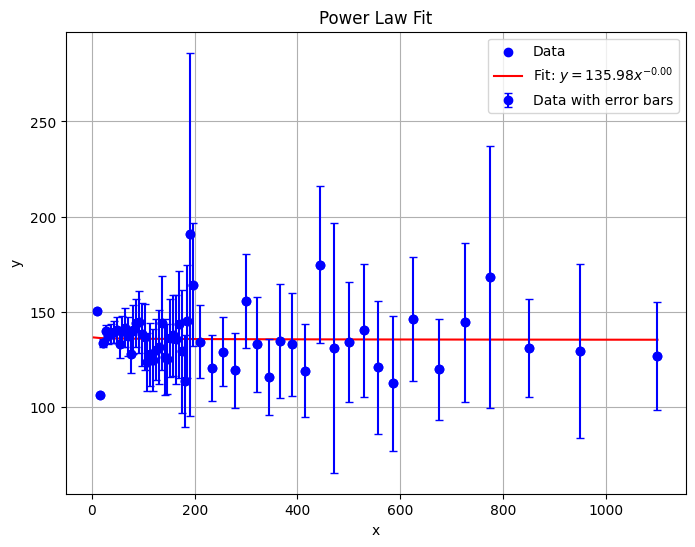

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Generate example data (y = 2 * x^1.5 with some noise)
np.random.seed(42)
n_tr=(binned_data_restricted['Num Points']/len(x_clean))
s_gsr=binned_data_restricted['Std Y']
r_bin=binned_data_restricted['Bin Center']
# Define the power-law function
def power_law(x, a, b):
    return a * (x/50)**b

# Fit the power law to the data
popt, pcov = curve_fit(power_law, r_bin, s_gsr, p0=(1, 1))  # Initial guesses for a and b
fitted_a_s, fitted_b_s = popt

# Generate fitted curve
x_fit = np.linspace(4, max(r_bin), 100)
y_fit = power_law(x_fit, fitted_a_s, fitted_b_s)

# Print results
print(f"Fitted parameters:")
print(f"a = {fitted_a_s:.3f}")
print(f"b = {fitted_b_s:.3f}")
N = np.array(binned_data_restricted['Num Points'])
error_bars=np.sqrt(1 / (2 * (N - 1))) * s_gsr
# Plot the data and the fit
plt.figure(figsize=(8, 6))
plt.scatter(r_bin,s_gsr , label='Data', color='blue')
plt.plot(x_fit, y_fit, label=f'Fit: $y = {fitted_a_s:.2f} x^{{{fitted_b_s:.2f}}}$', color='red')
plt.errorbar(r_bin, s_gsr, yerr=error_bars, fmt='o', label='Data with error bars', color='blue', capsize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Power Law Fit')
plt.legend()
plt.grid()
plt.show()


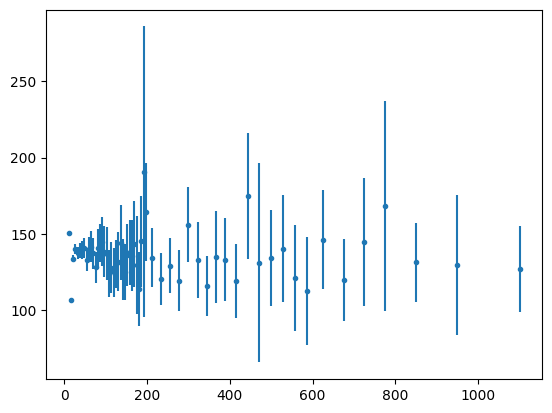

In [12]:
len(x_clean)

plt.errorbar(bin_centers,s_gsr,yerr=error_bars,fmt='.')


# Combine the arrays into a single 2D array
data = np.column_stack((bin_centers, s_gsr, error_bars))

# Save the data to a text file
#np.savetxt('trgb_mpc_20_s_bin.txt', data, fmt='%10.5f')


In [13]:
fitted_a1

7.121231339725272e-05

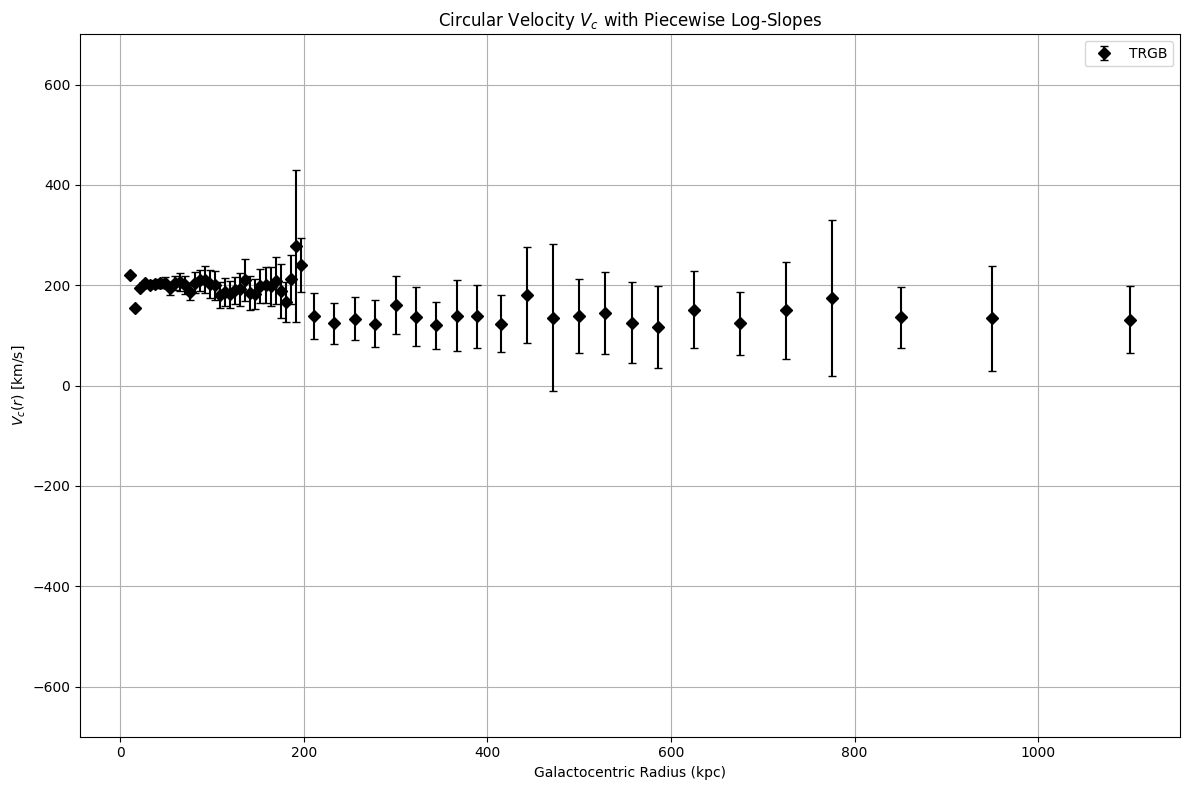

In [14]:
beta =0.0
r = np.array(binned_data_restricted['Bin Center']) * u.kpc
H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(abs((r + R0) / (r - R0)))

# Calculate sigma_r
sigma_r = np.array(binned_data_restricted['Std Y']) / np.sqrt(1 - beta * H_r)



# Build piecewise log derivatives
r_val = r.value
dln_ntr_dlR = np.where(r_val < 200, fitted_b1, fitted_b2)
dln_sigma_r2_dlR = np.where(r_val < 200, fitted_b_s,fitted_b_s)

# Calculate H_r
H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(np.abs((r + R0) / (r - R0)))



# Calculate V_c
V_c = np.sqrt(np.abs(-sigma_r**2 * (dln_ntr_dlR + dln_sigma_r2_dlR + 2 * beta)))

# Error in sigma_r and V_c
error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
error_ntr = np.sqrt(N)

error_V_c = np.sqrt(
    (2 * sigma_r * error_sigma_r / V_c)**2 +
    (sigma_r**2 * error_ntr / (V_c * N))**2
)

# Plot
plt.figure(figsize=(12, 8))
plt.errorbar(r_val, V_c, yerr=error_V_c, fmt='D', label='TRGB', color='k', capsize=3)
plt.ylim(-700, 700)
plt.xlabel('Galactocentric Radius (kpc)')
plt.ylabel(r'$V_c(r)$ [km/s]')
plt.title(r'Circular Velocity $V_c$ with Piecewise Log-Slopes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


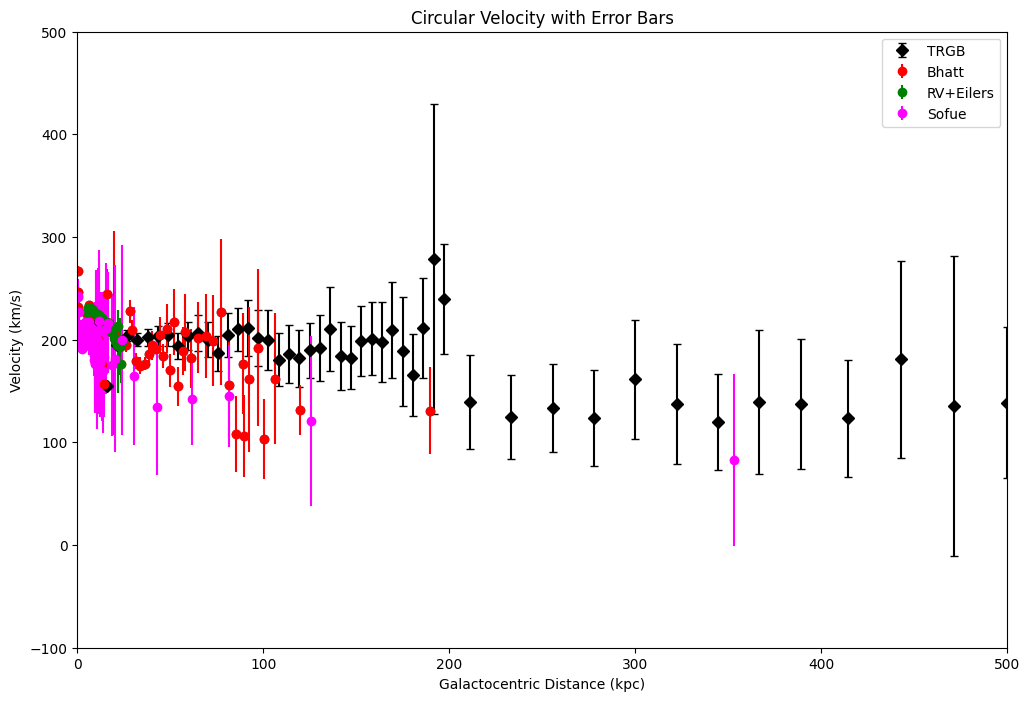

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

beta =0.0
r = np.array(binned_data_restricted['Bin Center']) * u.kpc
H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(abs((r + R0) / (r - R0)))

# Calculate sigma_r
sigma_r = np.array(binned_data_restricted['Std Y']) / np.sqrt(1 - beta * H_r)



# Build piecewise log derivatives
r_val = r.value
dln_ntr_dlR = np.where(r_val < 200, fitted_b1, fitted_b2)
dln_sigma_r2_dlR = np.where(r_val < 200, fitted_b_s,fitted_b_s)

# Calculate H_r
H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(np.abs((r + R0) / (r - R0)))



# Calculate V_c
V_c = np.sqrt(np.abs(-sigma_r**2 * (dln_ntr_dlR + dln_sigma_r2_dlR + 2 * beta)))

# Error in sigma_r and V_c
error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
error_ntr = np.sqrt(N)

error_V_c = np.sqrt(
    (2 * sigma_r * error_sigma_r / V_c)**2 +
    (sigma_r**2 * error_ntr / (V_c * N))**2
)

# Plot
plt.figure(figsize=(12, 8))
plt.errorbar(r_val, V_c, yerr=error_V_c, fmt='D', label='TRGB', color='k', capsize=3)
plt.ylim(-700, 700)
plt.xlabel('Galactocentric Radius (kpc)')
plt.ylabel(r'$V_c(r)$ [km/s]')
plt.title(r'Circular Velocity $V_c$ with Piecewise Log-Slopes')



data = np.loadtxt('bhatt_all.txt')
        


        # Extract x and y columns
x, y, e = data[:51, 2], data[:51, 3], data[:51, 4]


        # Plot the data

plt.scatter(x, y)
plt.errorbar(x, y,yerr=e, fmt='o', color='r', label='Bhatt')

data1 = np.loadtxt('MW_rotation_Eilers_2019.txt')
        


        # Extract x and y columns
x1, y1,e1 = data1[:, 0], data1[:, 1] ,data1[:,2]

        # Plot the data

plt.scatter(x1, y1)
plt.errorbar(x1, y1,yerr=e1, fmt='o', color='g', label='RV+Eilers')

data3 = np.loadtxt('Sofue.txt')

x3, y3, e3 = data3[:, 0], data3[:, 1] ,data3[:,2]

#plt.scatter(x3,y3, color='magenta', label='Sofue')
#plt.fill_between(x3, y3-e3, y3+e3, alpha=0.2, facecolor='magenta')
plt.errorbar(x3, y3, yerr=e3, fmt='o', color='magenta', label='Sofue')

#plt.xscale('log')

#plt.xlim(0, 500)
plt.ylim(-100, 500)


# Plot formatting

plt.xlabel('Galactocentric Distance (kpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Circular Velocity with Error Bars')
plt.legend()
plt.xlim(0,500)
plt.show()




DataFrame saved as trgb_mpc_20.txt


<ErrorbarContainer object of 3 artists>

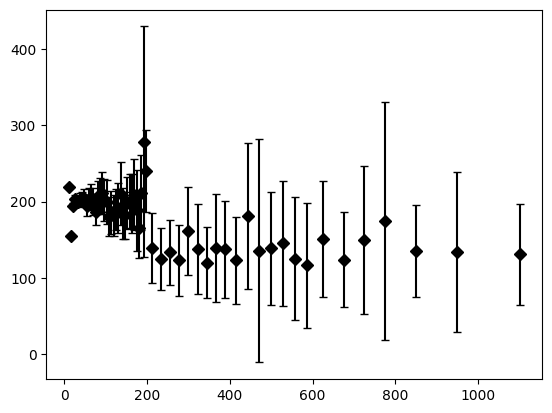

In [16]:
data = {
    '0': np.array(binned_data_restricted['Bin Center']),
    '1': V_c,
    '2': error_V_c
}
df = pd.DataFrame(data)

# Save as a .txt file (tab-delimited)
txt_file_path = "trgb_mpc_20.txt"
df.to_csv(txt_file_path, sep='\t', index=False)

print(f"DataFrame saved as {txt_file_path}")
# Plot V_c with error bars
plt.errorbar(
    np.array(binned_data_restricted['Bin Center']),
    V_c,
    yerr=error_V_c,
    fmt='D',
    label='Circular Velocity (V_c)',
    color='k',
    capsize=3
)

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
G3_sdss = np.loadtxt('GC_gdr3.txt')
        


        # Extract x and y columns
x1, y1,e1 = G3_sdss[1:, 0], G3_sdss[1:, 1] ,G3_sdss[1:,2]

        # Plot the data


plt.errorbar(x1, y1,yerr=e1, fmt='^', color='c', label='Data',capsize=3)



plt.xlim(0,200)


# Plot formatting

plt.xlabel('Galactocentric Distance (kpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Circular Velocity with Error Bars')
plt.legend()
plt.grid()
plt.show()

FileNotFoundError: GC_gdr3.txt not found.

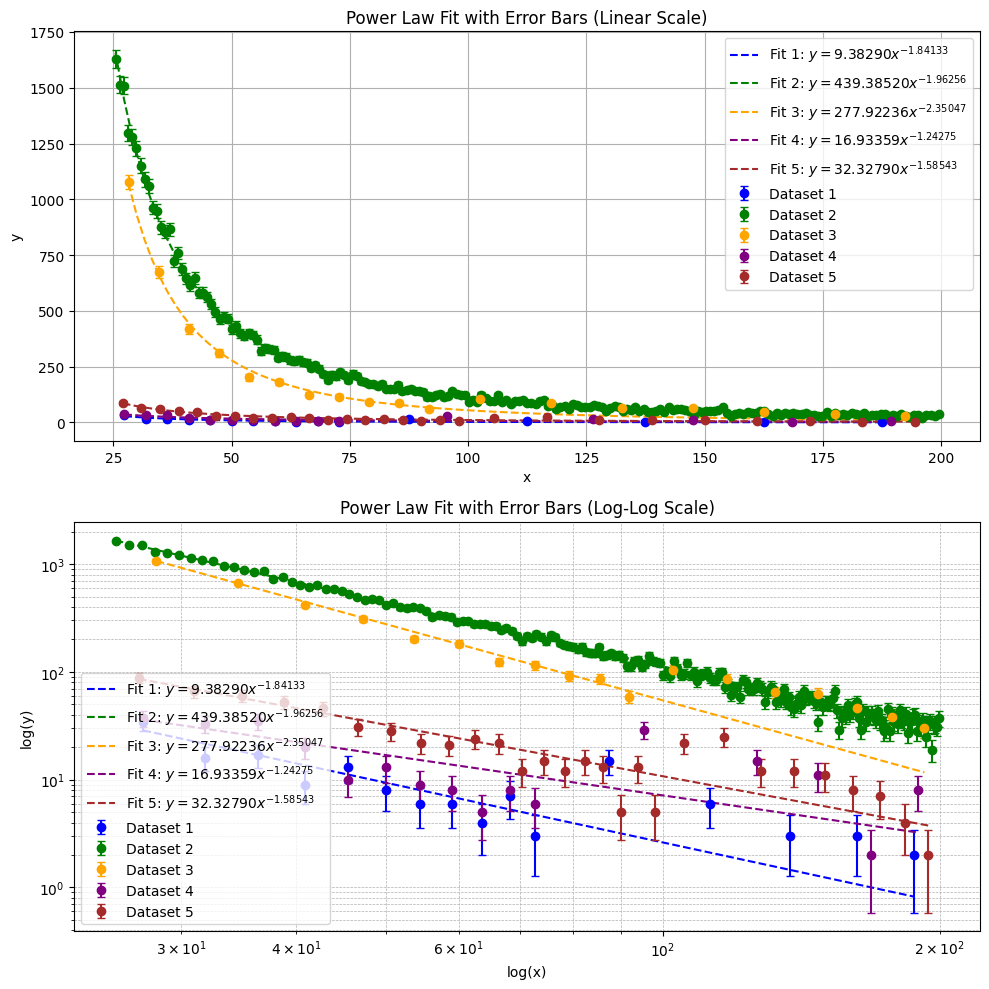

Dataset 1:
a = 9.382896263
b = -1.841332437

Dataset 2:
a = 439.385200752
b = -1.962563771

Dataset 3:
a = 277.922359476
b = -2.350470210

Dataset 4:
a = 16.933588329
b = -1.242754990

Dataset 5:
a = 32.327895657
b = -1.585426423



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the power-law function
def power_law(x, a, b):
    return a * (x / 50)**b

# List of text files (replace with actual file names)
file_list = ["lpv_s_bin.txt","cep_s_bin.txt","trgb_s_bin.txt","rs_s_bin.txt","oab_s_bin.txt"]  # Add your text files here

# Initialize lists to store fitted parameters
fitted_parameters = []
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']  # For plotting

# Create a figure with two subplots
plt.figure(figsize=(10, 10))

# Loop through each file and process the data
for i, file_name in enumerate(file_list):
    # Load data from the file
    data = np.loadtxt(file_name)
    x, y, y_err = data[:, 0], data[:, 1], data[:, 2]

    # Filter data for x >= 20
    filter_mask = x >= 20
    x_filtered = x[filter_mask]
    y_filtered = y[filter_mask]
    y_err_filtered = y_err[filter_mask]

    # Fit the power law to the filtered data
    popt, pcov = curve_fit(power_law, x_filtered, y_filtered, p0=(1, 1))
    fitted_a, fitted_b = popt
    fitted_parameters.append((fitted_a, fitted_b))

    # Generate fitted curve
    x_fit = np.linspace(min(x_filtered), max(x_filtered), 100)
    y_fit = power_law(x_fit, fitted_a, fitted_b)

    # Plot the data with error bars (Linear scale)
    plt.subplot(2, 1, 1)
    plt.errorbar(x_filtered, y_filtered, yerr=y_err_filtered, fmt='o', label=f'Dataset {i + 1}', color=colors[i % len(colors)], capsize=3)
    plt.plot(x_fit, y_fit, label=f'Fit {i + 1}: $y = {fitted_a:.5f} x^{{{fitted_b:.5f}}}$', linestyle='--', color=colors[i % len(colors)])

    # Plot the data with error bars (Log-log scale)
    plt.subplot(2, 1, 2)
    plt.errorbar(x_filtered, y_filtered, yerr=y_err_filtered, fmt='o', label=f'Dataset {i + 1}', color=colors[i % len(colors)], capsize=3)
    plt.plot(x_fit, y_fit, label=f'Fit {i + 1}: $y = {fitted_a:.5f} x^{{{fitted_b:.5f}}}$', linestyle='--', color=colors[i % len(colors)])

# Customize the Linear Scale plot
plt.subplot(2, 1, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Power Law Fit with Error Bars (Linear Scale)')
plt.legend()
plt.grid()

# Customize the Log-Log Scale plot
plt.subplot(2, 1, 2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log(x)')
plt.ylabel('log(y)')
plt.title('Power Law Fit with Error Bars (Log-Log Scale)')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Finalize and show the plots
plt.tight_layout()
plt.show()

# Print all fitted parameters
for i, (a, b) in enumerate(fitted_parameters):
    print(f"Dataset {i + 1}:")
    print(f"a = {a:.9f}")
    print(f"b = {b:.9f}")
    print()


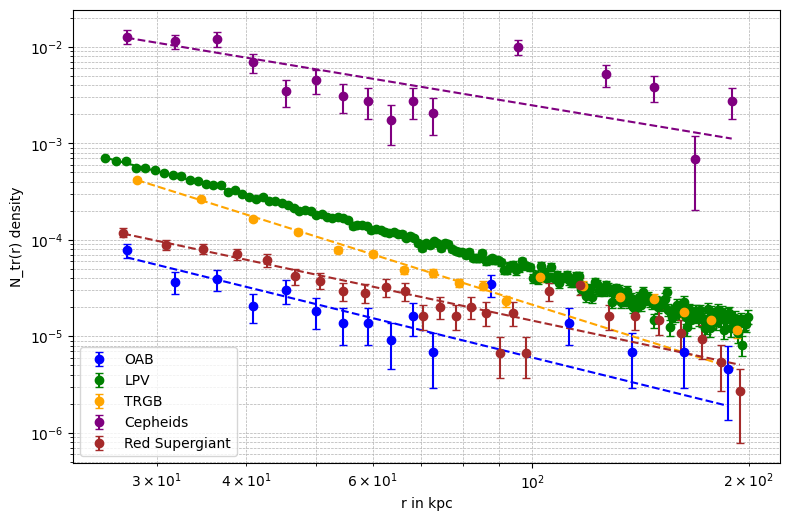

Dataset 1:
a = 0.000021528
b = -1.841260422

Dataset 2:
a = 0.000188920
b = -1.962563776

Dataset 3:
a = 0.000108227
b = -2.350465058

Dataset 4:
a = 0.005873550
b = -1.242788624

Dataset 5:
a = 0.000043553
b = -1.585424183



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the power-law function
def power_law(x, a, b):
    return a * (x / 50)**b

# List of text files containing (x, y, y_err)
file_list = ["OAB_num_bin.txt","LPV_num_bin.txt","TRGB_num_bin.txt","Cep_num_bin.txt","CRS_num_bin.txt"]  # Replace with actual file paths
labels = [
   "OAB","LPV","TRGB","Cepheids","Red Supergiant"
] 
# Scaling factors for each dataset (corresponds to file_list)
scaling_factors = np.array([435848, 2325775,2567955,2883,742263])  # Replace with your actual scaling factors

# Initialize lists to store fitted parameters
fitted_parameters = []
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']  # For plotting

# Create a figure with two subplots
plt.figure(figsize=(8,10))

# Loop through each file and process the data
for i, file_name in enumerate(file_list):
    # Load data from the file
    data = np.loadtxt(file_name)
    x, y, y_err = data[:, 0], data[:, 1], data[:, 2]
    
    # Apply scaling factor to y component
    y_scaled = y / scaling_factors[i]
    y_err_scaled = y_err / scaling_factors[i]
    
    # Filter data for x >= 20
    filter_mask = x >= 20
    x_filtered = x[filter_mask]
    y_filtered = y_scaled[filter_mask]
    y_err_filtered = y_err_scaled[filter_mask]

    # Fit the power law to the filtered data
    popt, pcov = curve_fit(power_law, x_filtered, y_filtered, p0=(1, 1))
    fitted_a, fitted_b = popt
    fitted_parameters.append((fitted_a, fitted_b))

    # Generate fitted curve
    x_fit = np.linspace(min(x_filtered), max(x_filtered), 100)
    y_fit = power_law(x_fit, fitted_a, fitted_b)

    

    # Plot the data with error bars (Log-log scale)
    plt.subplot(2, 1, 2)
    plt.errorbar(x_filtered, y_filtered, yerr=y_err_filtered, fmt='o',label=f'{labels[i]}', color=colors[i % len(colors)], capsize=3)
    plt.plot(x_fit, y_fit, linestyle='--', color=colors[i % len(colors)])



# Customize the Log-Log Scale plot
plt.subplot(2, 1, 2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r in kpc')
plt.ylabel('N_tr(r) density')
#plt.title('Power Law Fit n_tr(r) vs r (Log-Log Scale)')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Finalize and show the plots
plt.tight_layout()
plt.show()

# Print all fitted parameters
for i, (a, b) in enumerate(fitted_parameters):
    print(f"Dataset {i + 1}:")
    print(f"a = {a:.9f}")
    print(f"b = {b:.9f}")
    print()


TypeError: string indices must be integers

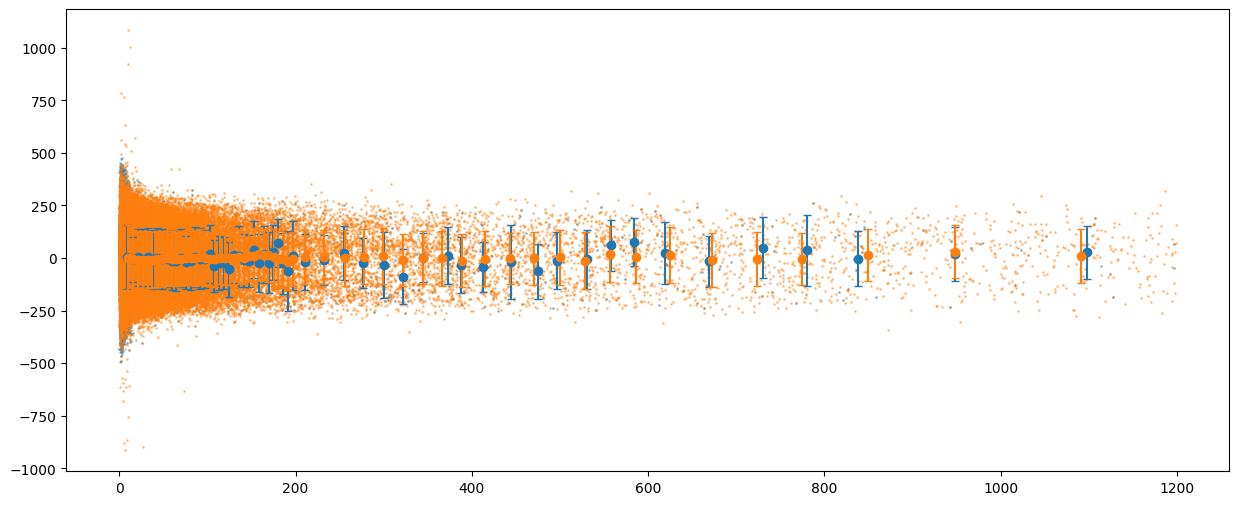

In [ ]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt

# Constants
U_sun, V_sun, W_sun = 11.1 * u.km/u.s, 12.24 * u.km/u.s, 7.25 * u.km/u.s
V0, R0 = 229 * u.km/u.s, 8.1 * u.kpc

# Coordinate transformation
def transform_to_galactocentric(df):
    ra, dec = df['ra'].values * u.deg, df['dec'].values * u.deg
    d = (df['parallax'].values * u.mas).to(u.kpc, u.parallax())
    pm_ra, pm_dec = df['pmra'].values * u.mas/u.yr, df['pmdec'].values * u.mas/u.yr
    rv = df['radial_velocity'].values * u.km/u.s
    l, b = df['l'].values * u.deg, df['b'].values * u.deg

    c = SkyCoord(ra=ra, dec=dec, distance=d, pm_ra_cosdec=pm_ra, pm_dec=pm_dec, radial_velocity=rv)
    g = c.transform_to(Galactocentric(galcen_distance=R0, z_sun=0.020 * u.kpc, galcen_v_sun=[U_sun, V_sun, W_sun]))

    x, y = g.x.value, g.y.value
    R = np.sqrt(x**2 + y**2)

    v_gsr = rv + U_sun*np.cos(b)*np.cos(l) + V_sun*np.cos(b)*np.sin(l) + W_sun*np.sin(b) + V0*np.cos(b)*np.sin(l)
    r = np.sqrt(R0.value**2 + d.value**2 - 2*R0.value*d.value*np.cos(b)*np.cos(l))
    return R, v_gsr.value, r

# Binning and processing per file
def process_file(file_path, label, custom_bins):
    df = pd.read_csv(file_path)
    R, v_gsr, _ = transform_to_galactocentric(df)

    mask = ~np.isnan(R) & ~np.isnan(v_gsr) & (R <= custom_bins[-1])
    R, v_gsr = R[mask], v_gsr[mask]

    mean_x, _, _ = binned_statistic(R, R, bins=custom_bins, statistic='mean')
    mean_y, _, _ = binned_statistic(R, v_gsr, bins=custom_bins, statistic='mean')
    std_y, _, _ = binned_statistic(R, v_gsr, bins=custom_bins, statistic='std')
    count, _, _ = binned_statistic(R, v_gsr, bins=custom_bins, statistic='count')

    bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])
    binned_df = pd.DataFrame({
        'Bin Center': bin_centers,
        'Mean X': mean_x,
        'Mean Y': mean_y,
        'Std Y': std_y,
        'Count': count,
        'Label': label
    }).dropna()

    return R, v_gsr, binned_df

# Define per-file configs (filename, label, custom bin edges)
file_configs = [
    {
        'path': 'TRGB_Gaia_new-result.csv',
        'label': 'Dataset 1',
        'bins': np.concatenate([
            np.linspace(8, 100, 18),
            np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:], 
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:], 
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], 
            np.linspace(1000, 1200, 2)[1:]
        ])
    },
 {
        'path': 'LPV_Gaia_new-result.csv',
        'label': 'Dataset 1',
        'bins': np.concatenate([
            np.linspace(8, 100, 18),
            np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:], 
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:], 
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], 
            np.linspace(1000, 1200, 2)[1:]
        ])
    },
    """{
        'path': 'other_file_2.csv',
        'label': 'Dataset 3',
        'bins': np.concatenate([
            np.linspace(20, 200, 15),
            np.linspace(200, 600, 6)[1:],
            np.linspace(600, 1000, 4)[1:]
        ])
    }"""
]

# Plotting
plt.figure(figsize=(15, 6))
for config in file_configs:
    try:
        R, v_gsr, binned = process_file(config['path'], config['label'], config['bins'])
        plt.scatter(R, v_gsr, s=1, alpha=0.4, label=f'Raw {config["label"]}')
        plt.errorbar(binned['Mean X'], binned['Mean Y'], yerr=binned['Std Y'], fmt='o',
                     capsize=3, label=f'Binned {config["label"]}')
    except Exception as e:
        print(f"Error processing {config['label']}: {e}")

plt.xlabel('Galactocentric Radius R (kpc)')
plt.ylabel('v_gsr (km/s)')
plt.title('Galactocentric Radial Velocity vs Radius with Custom Binning')
plt.xlim(0, 1200)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[TRGB] < 200 kpc: a = 7.12124e-05, b = -2.12606
[TRGB] ≥ 200 kpc: a = 4.80913e-05, b = -1.07030
[LPV] < 200 kpc: a = 6.00299e-03, b = -1.92185
[LPV] ≥ 200 kpc: a = 8.06308e-03, b = -1.30571


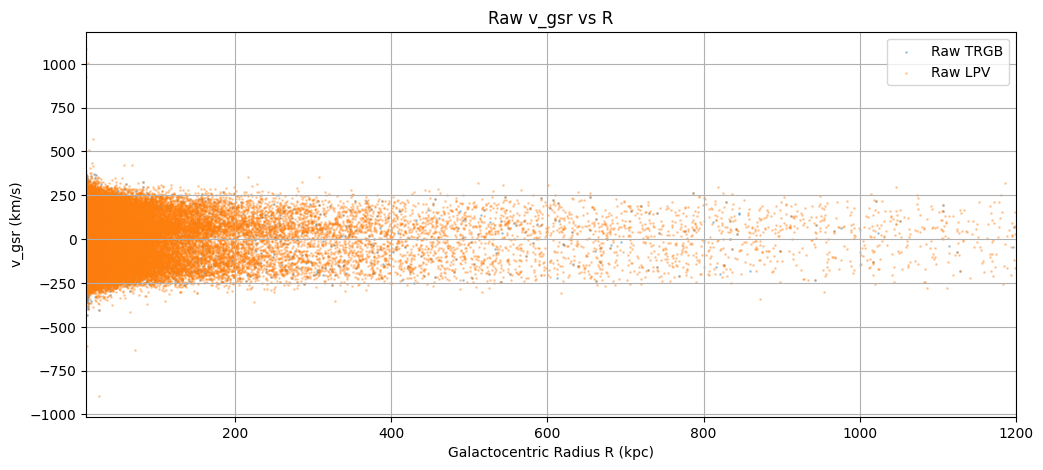

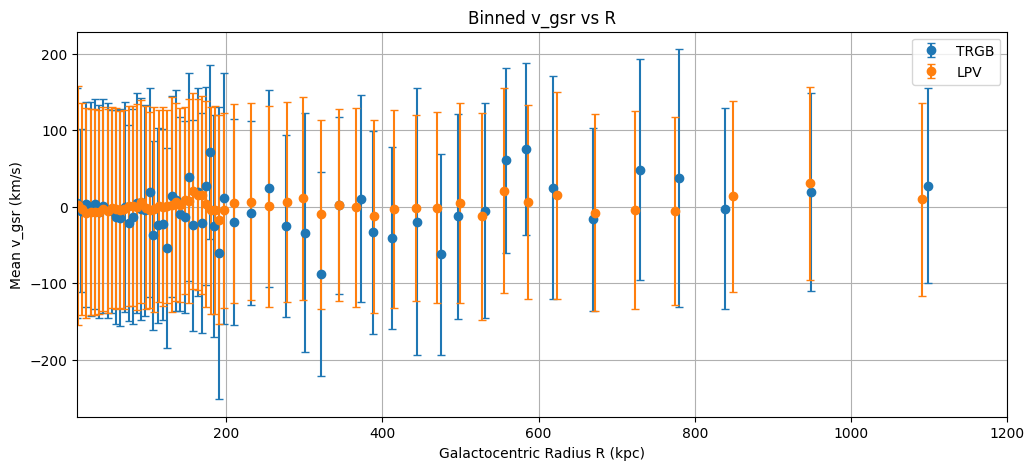

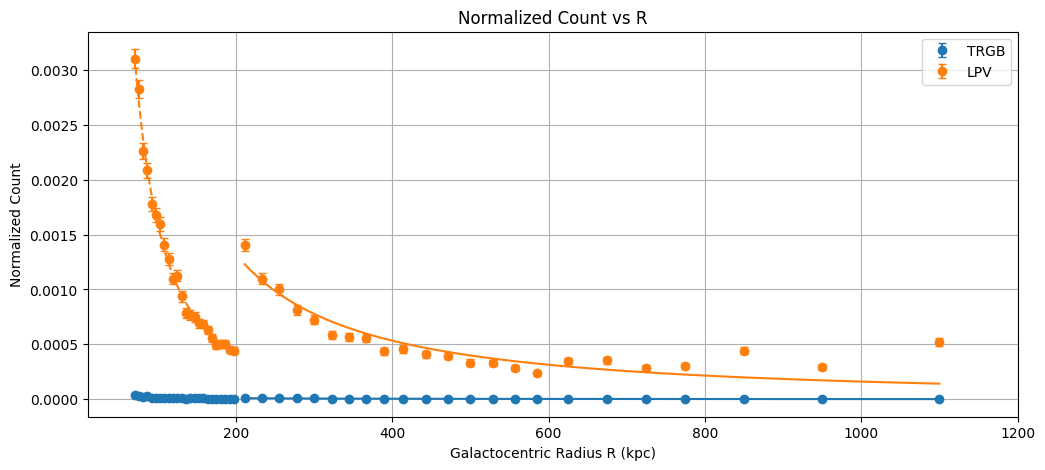

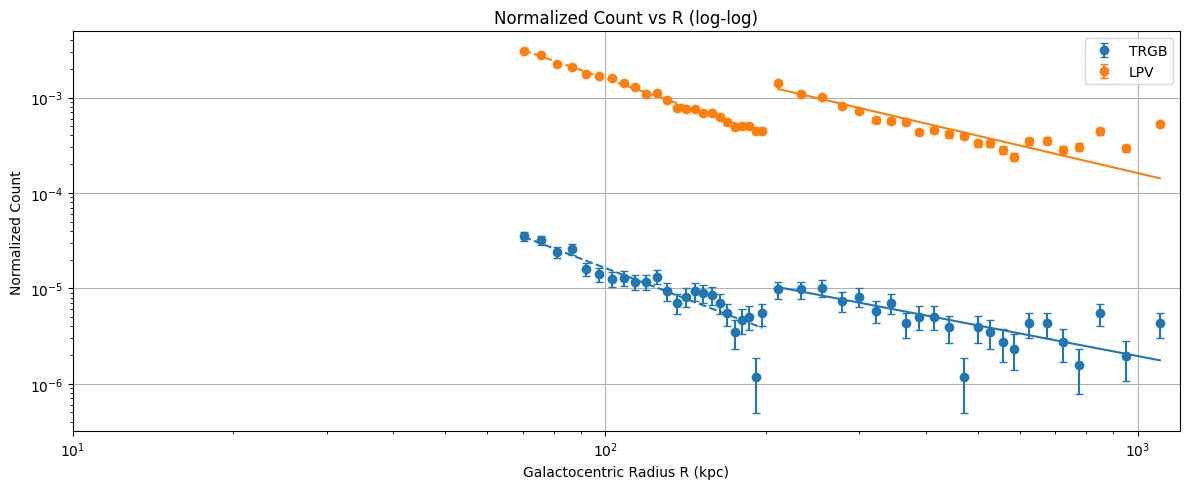

In [ ]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Constants
U_sun, V_sun, W_sun = 11.1 * u.km/u.s, 12.24 * u.km/u.s, 7.25 * u.km/u.s
V0, R0 = 229 * u.km/u.s, 8.1 * u.kpc

def transform_to_galactocentric(df):
    ra, dec = df['ra'].values * u.deg, df['dec'].values * u.deg
    d = (df['parallax'].values * u.mas).to(u.kpc, u.parallax())
    pm_ra, pm_dec = df['pmra'].values * u.mas/u.yr, df['pmdec'].values * u.mas/u.yr
    rv = df['radial_velocity'].values * u.km/u.s
    l, b = df['l'].values * u.deg, df['b'].values * u.deg

    c = SkyCoord(ra=ra, dec=dec, distance=d, pm_ra_cosdec=pm_ra, pm_dec=pm_dec, radial_velocity=rv)
    g = c.transform_to(Galactocentric(galcen_distance=R0, z_sun=0.020 * u.kpc, galcen_v_sun=[U_sun, V0 + V_sun, W_sun]))

    x, y = g.x.value, g.y.value
    R = np.sqrt(x**2 + y**2)

    v_gsr = rv + U_sun*np.cos(b)*np.cos(l) + V_sun*np.cos(b)*np.sin(l) + W_sun*np.sin(b) + V0*np.cos(b)*np.sin(l)
    r = np.sqrt(R0.value**2 + d.value**2 - 2*R0.value*d.value*np.cos(b)*np.cos(l))

    return R, v_gsr.value, r

def process_file(file_path, label, custom_bins):
    df = pd.read_csv(file_path)
    R, v_gsr, _ = transform_to_galactocentric(df)

    mask = ~np.isnan(R) & ~np.isnan(v_gsr) & (R <= custom_bins[-1])
    R, v_gsr = R[mask], v_gsr[mask]

    mean_x = binned_statistic(R, R, bins=custom_bins, statistic='mean')[0]
    mean_y = binned_statistic(R, v_gsr, bins=custom_bins, statistic='mean')[0]
    std_y = binned_statistic(R, v_gsr, bins=custom_bins, statistic='std')[0]
    count = binned_statistic(R, v_gsr, bins=custom_bins, statistic='count')[0]

    bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])
    binned_df = pd.DataFrame({
        'Bin Center': bin_centers,
        'Mean X': mean_x,
        'Mean Y': mean_y,
        'Std Y': std_y,
        'Num Points': count,
        'Label': label
    }).dropna()

    return R, v_gsr, binned_df

def power_law(x, a, b):
    return a * (x / 50)**b

# Dataset configurations
file_configs = [
    {
        'path': 'TRGB_Gaia_new-result.csv',
        'label': 'TRGB',
        'bins': np.concatenate([
            np.linspace(8, 100, 18),
            np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:], 
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:], 
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], 
            np.linspace(1000, 1200, 2)[1:]
        ])
    },
    {
        'path': 'LPV_Gaia_new-result.csv',
        'label': 'LPV',
        'bins': np.concatenate([
            np.linspace(8, 100, 18),
            np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:], 
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:], 
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], 
            np.linspace(1000, 1200, 2)[1:]
        ])
    }
]

# Prepare plots
fig1, ax1 = plt.subplots(figsize=(12, 5))  # Raw velocities
fig2, ax2 = plt.subplots(figsize=(12, 5))  # Binned mean v_gsr
fig3, ax3 = plt.subplots(figsize=(12, 5))  # Normalized count (linear)
fig4, ax4 = plt.subplots(figsize=(12, 5))  # Normalized count (log-log)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, config in enumerate(file_configs):
    try:
        R, v_gsr, binned_df = process_file(config['path'], config['label'], config['bins'])
        color = colors[i % len(colors)]

        # Raw scatter
        ax1.scatter(R, v_gsr, s=1, alpha=0.3, label=f'Raw {config["label"]}', color=color)

        # Binned v_gsr
        ax2.errorbar(binned_df['Mean X'], binned_df['Mean Y'], yerr=binned_df['Std Y'], fmt='o', capsize=3, label=f'{config["label"]}', color=color)

        # Power-law fit
        r_bin = binned_df['Bin Center'].values
        n_tr = binned_df['Num Points'].values / len(R)
        valid_mask = r_bin >= 70
        r_bin_valid, n_tr_valid = r_bin[valid_mask], n_tr[valid_mask]

        # Low and high radius mask
        r_bin_low, n_tr_low = r_bin_valid[r_bin_valid < 200], n_tr_valid[r_bin_valid < 200]
        r_bin_high, n_tr_high = r_bin_valid[r_bin_valid >= 200], n_tr_valid[r_bin_valid >= 200]

        popt_low, _ = curve_fit(power_law, r_bin_low, n_tr_low, p0=(1, 1))
        popt_high, _ = curve_fit(power_law, r_bin_high, n_tr_high, p0=(1, 1))

        # Fit curves
        x_fit_low = np.linspace(r_bin_low.min(), r_bin_low.max(), 100)
        x_fit_high = np.linspace(r_bin_high.min(), r_bin_high.max(), 100)
        y_fit_low = power_law(x_fit_low, *popt_low)
        y_fit_high = power_law(x_fit_high, *popt_high)

        ax3.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
        ax3.plot(x_fit_low, y_fit_low, '--', color=color)
        ax3.plot(x_fit_high, y_fit_high, '-', color=color)

        ax4.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
        ax4.plot(x_fit_low, y_fit_low, '--', color=color)
        ax4.plot(x_fit_high, y_fit_high, '-', color=color)

        print(f"[{config['label']}] < 200 kpc: a = {popt_low[0]:.5e}, b = {popt_low[1]:.5f}")
        print(f"[{config['label']}] ≥ 200 kpc: a = {popt_high[0]:.5e}, b = {popt_high[1]:.5f}")

    except Exception as e:
        print(f"Error processing {config['label']}: {e}")

# Finalize plots
for ax, title, ylab, xlog, ylog in zip(
    [ax1, ax2, ax3, ax4],
    ['Raw v_gsr vs R', 'Binned v_gsr vs R', 'Normalized Count vs R', 'Normalized Count vs R (log-log)'],
    ['v_gsr (km/s)', 'Mean v_gsr (km/s)', 'Normalized Count', 'Normalized Count'],
    [False, False, False, True],
    [False, False, False, True]
):
    ax.set_xlabel('Galactocentric Radius R (kpc)')
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    if xlog: ax.set_xscale('log')
    if ylog: ax.set_yscale('log')
    ax.set_xlim(10, 1200)

plt.tight_layout()
plt.show()


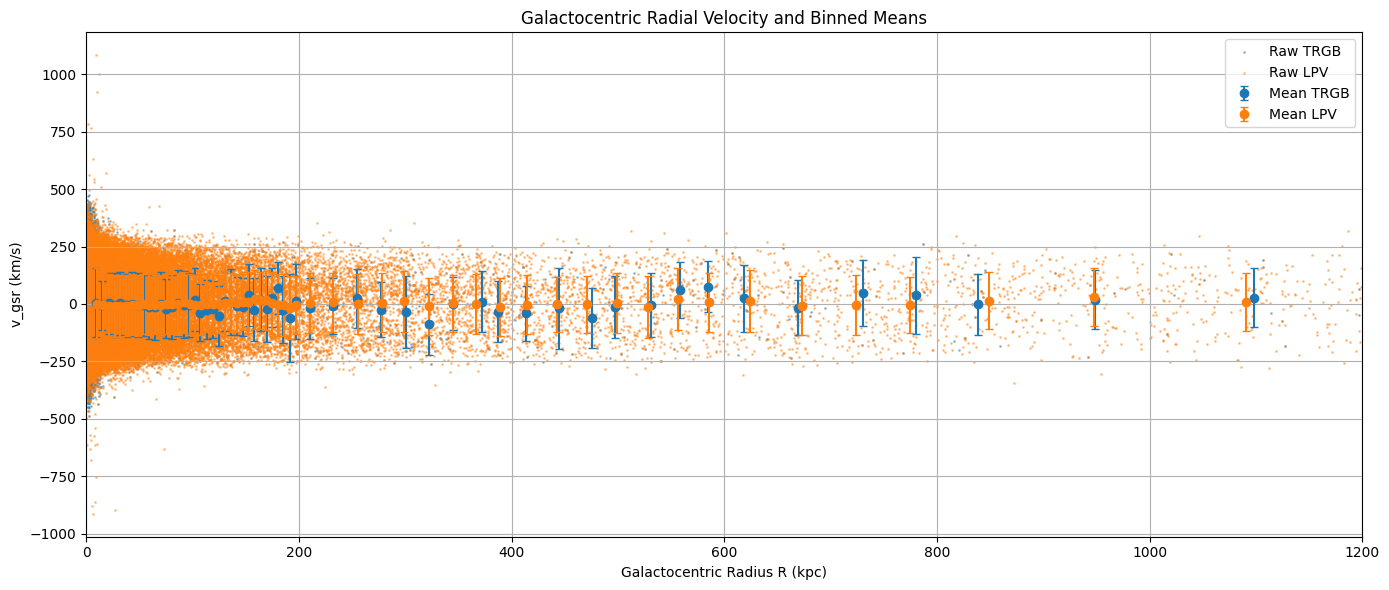

[TRGB] < 200 kpc: a = 7.12124e-05, b = -2.12606
[TRGB] ≥ 200 kpc: a = 4.80913e-05, b = -1.07030
[LPV] < 200 kpc: a = 6.00299e-03, b = -1.92185
[LPV] ≥ 200 kpc: a = 8.06308e-03, b = -1.30571


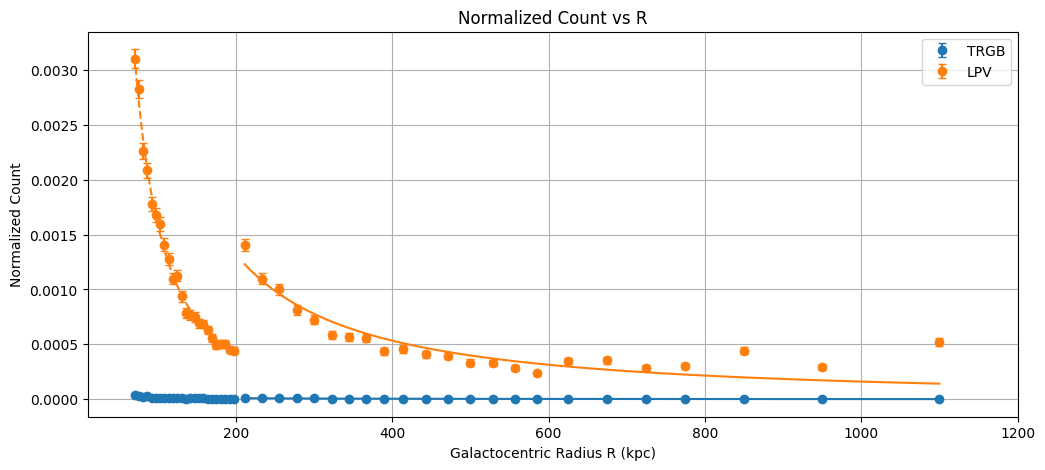

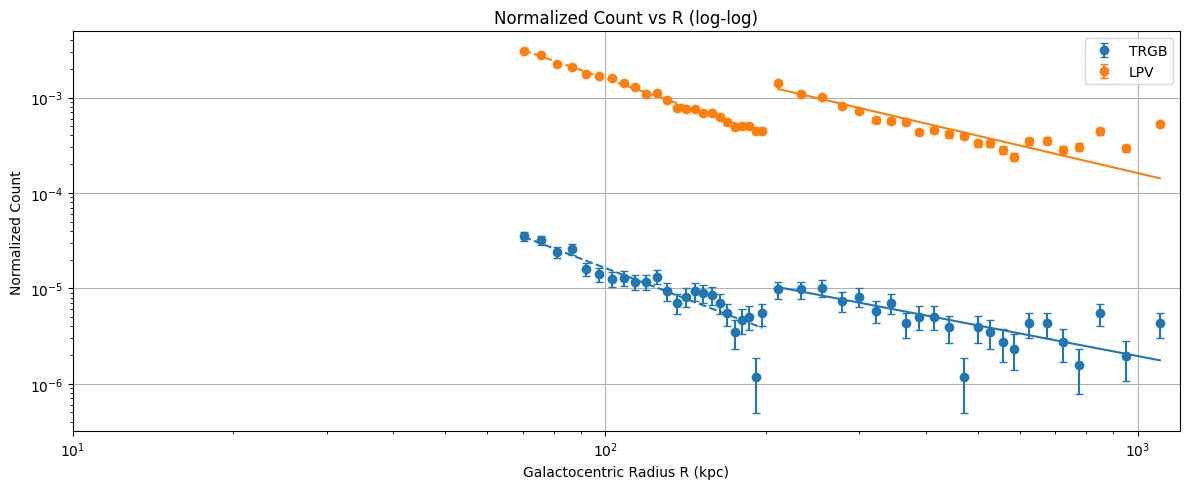

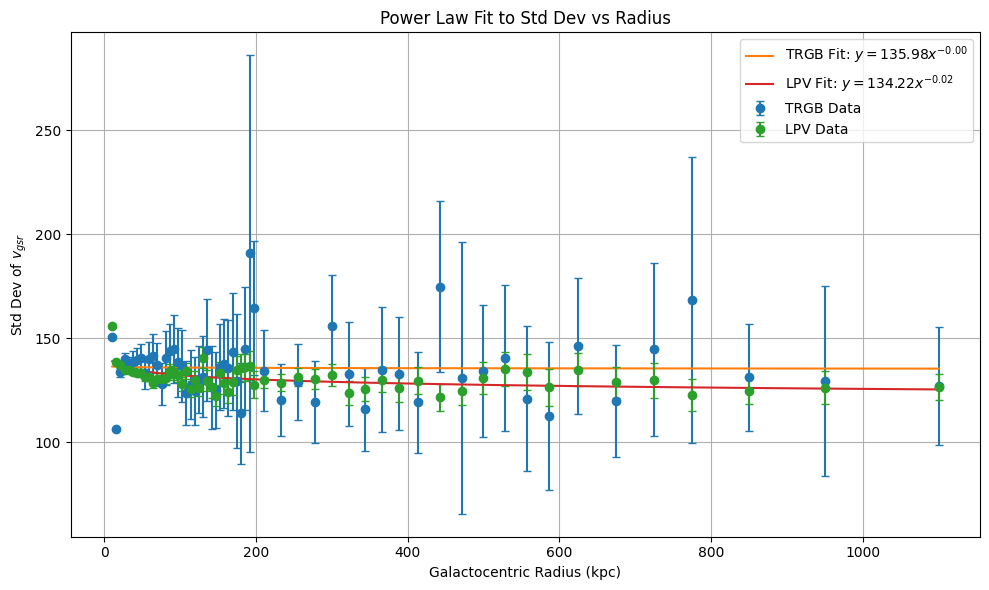